In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
import pandas as pd
import re
import warnings
import random
import matplotlib
from tqdm.notebook import tqdm
from matplotlib.patches import Patch
from scipy.stats import linregress, spearmanr
import analysis_utils
from copy import deepcopy

# path to repository folder (data is stored here as well)
path = '..'
preds_loc = os.path.join(path, 'data', 's669_mapped_preds.csv')

# default plotting settings
font = {'size'   : 18}
matplotlib.rc('font', **font)

# notebook display options
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 300

remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

In [2]:
db = pd.read_csv(preds_loc, index_col=0)
db['uid2'] = db['code'] + '_' + db['position'].astype(int).astype(str) + db['mutation'].str[-1]
db = db.reset_index().set_index(['uid', 'uid2'])

# create and use a third index for matching with the S461 subset
db_full = db.copy(deep=True)
db_full['uid3'] = db['code'] + '_' + db['PDB_Mut'].str[1:]
db_full = db_full.reset_index().set_index('uid3')

# preprocess S461 to align with S669
s461 = pd.read_csv(os.path.join(path, 'data', 'S461.csv'))
s461['uid3'] = s461['PDB'] + '_' + s461['MUT_D'].str[2:]
s461 = s461.set_index('uid3')
s461['ddG_I'] = -s461['ddG_D']
s461.columns = [s+'_dir' for s in s461.columns]
s461 = s461.rename({'ddG_D_dir': 'ddG_dir', 'ddG_I_dir': 'ddG_inv'}, axis=1)

# merge S669 with S461 (keeping predictions from both for comparison purposes)
db = s461.join(db_full, how='left').reset_index(drop=True).set_index(['uid', 'uid2'])

preds_loc = preds_loc.replace('s669', 's461')
db.to_csv(preds_loc)
db

PDB_dir MUT_D_dir  ddG_dir  KORPMD_dir  CartddgD_dir  \
uid       uid2                                                             
1A0F_11A  1A0F_11A     1A0F     SA11A   -1.800       0.138          1.45   
1BA3_461D 1BA3_457D    1BA3    HA461D   -1.745      -1.065         -4.47   
1BA3_489D 1BA3_485D    1BA3    HA489D    0.287       0.270          0.64   
1BA3_489K 1BA3_485K    1BA3    HA489K   -0.287       0.398          0.86   
1BA3_489M 1BA3_485M    1BA3    HA489M   -0.263      -0.211         -1.08   
...                     ...       ...      ...         ...           ...   
4HE7_19G  4HE7_19G     4HE7     AA19G    0.060      -0.249         -2.20   
4HE7_19K  4HE7_19K     4HE7     AA19K   -0.460      -0.063          0.59   
5JXB_329G 5JXB_25G     5JXB    DA329G   -1.440      -0.426         -4.72   
5JXB_329P 5JXB_25P     5JXB    DA329P   -1.440      -0.930         -8.00   
5OAQ_429H 5OAQ_199H    5OAQ    YA429H   -2.990      -2.512         -8.00   

                     FoldXD_dir  EvoD_dir  Dyna2D_dir  PopMsD_dir  DDGunD_dir  \
uid       uid2                                                                  
1A0F_11A  1A0F_11A         0.48     -0.37       0.545       -1.04         0.5   
1BA3_461D 1BA3_457D       -0.86     -0.77       0.160       -1.19        -1.2   
1BA3_489D 1BA3_485D       -0.13      0.96      -0.193        0.07        -0.1   
1BA3_489K 1BA3_485K        0.19      1.12       0.190        0.26        -0.1   
1BA3_489M 1BA3_485M        0.30      1.42      -0.138        0.29         0.0   
...                         ...       ...         ...         ...         ...   
4HE7_19G  4HE7_19G        -0.04     -0.71      -0.133       -0.83        -0.4   
4HE7_19K  4HE7_19K         0.04      0.18      -0.119       -0.46        -0.3   
5JXB_329G 5JXB_25G        -0.85     -0.53       0.694       -0.05        -0.3   
5JXB_329P 5JXB_25P        -0.97      0.42       0.390       -0.06        -0.2   
5OAQ_429H 5OAQ_199H       -3.64     -4.12      -0.411       -2.46        -2.4   

                     ...  runtime_esm1v_mean_dir   ankh_dir  runtime_ankh_dir  \
uid       uid2       ...                                                        
1A0F_11A  1A0F_11A   ...               17.231578  -7.887412          2.616761   
1BA3_461D 1BA3_457D  ...                0.430420  -7.608351          0.262573   
1BA3_489D 1BA3_485D  ...                0.434490  -1.200629          0.261357   
1BA3_489K 1BA3_485K  ...                0.435225   1.806133          0.261200   
1BA3_489M 1BA3_485M  ...                0.437405  -2.251678          0.261075   
...                  ...                     ...        ...               ...   
4HE7_19G  4HE7_19G   ...                0.178473   1.126451          0.116848   
4HE7_19K  4HE7_19K   ...                0.180149   1.297788          0.124019   
5JXB_329G 5JXB_25G   ...                0.563628  -7.322987          0.377666   
5JXB_329P 5JXB_25P   ...                0.570944 -11.226997          0.377821   
5OAQ_429H 5OAQ_199H  ...                0.362168  -4.849787          0.208365   

                      mif_dir  runtime_mif_dir  mifst_dir  runtime_mifst_dir  \
uid       uid2                                                                 
1A0F_11A  1A0F_11A  -4.844777        39.220242  -9.079479           3.273667   
1BA3_461D 1BA3_457D -5.867596         0.028498  -5.932082           0.073094   
1BA3_489D 1BA3_485D  0.832934         0.027859   1.415697           0.060803   
1BA3_489K 1BA3_485K  2.481171         0.027850   2.924172           0.060263   
1BA3_489M 1BA3_485M -2.501084         0.027764  -2.145448           0.060485   
...                       ...              ...        ...                ...   
4HE7_19G  4HE7_19G  -3.652388         0.004464  -3.275250           0.025712   
4HE7_19K  4HE7_19K   0.307017         0.004445   0.532605           0.025569   
5JXB_329G 5JXB_25G  -0.133779         0.007516 -11.341687           0.042824   
5JXB_329P 5JXB_25P  -3.983828         0.007

In [3]:
### RUN HOMOLOGY ANALYSIS TO GENERATE PREDS_CLUSTERS

In [4]:
db = pd.read_csv(preds_loc.replace('preds.csv', 'preds_clusters.csv')).set_index(['uid', 'uid2'])
db_runtimes = db[[col for col in db.columns if 'runtime' in col]]

db = db.reset_index().rename({'uid': 'uid_'}, axis=1).rename({'uid2': 'uid'}, axis=1).set_index('uid')
# extract the runtimes for methods that have it (not currently used)
db_runtimes = db_runtimes.reset_index().rename({'uid': 'uid_'}, axis=1).rename({'uid2': 'uid'}, axis=1).set_index('uid')
print('getting cartesian predictions')
# assuming you have designated the repo location as the path
df_cart, df_cart_runtimes = analysis_utils.parse_rosetta_predictions(db, os.path.join(path, 'data', 'rosetta_predictions'), runtime=True)
db = db.join(df_cart.astype(float), how='left').reset_index().rename({'uid': 'uid2'}, axis=1).rename({'uid_': 'uid'}, axis=1).set_index(['uid', 'uid2'])
db_runtimes = db_runtimes.join(df_cart_runtimes, how='left').reset_index().rename({'uid': 'uid2'}, axis=1).rename({'uid_': 'uid'}, axis=1).set_index(['uid', 'uid2'])
db_runtimes['runtime_korpm'] = 0.0015

original_pred_cols = [c for c in db.columns if '_dir' in c and not 'runtime' in c and not 'pll' in c and not 'ddG' in c]
for col in ['PDB_dir', 'MUT_D_dir', 'SEC_STR_dir', 'SOL_ACC_dir']:
    original_pred_cols.remove(col)
original_pred_cols_reduced = deepcopy(original_pred_cols)
for col in [f'esm1v_{i}_dir' for i in range(1,6)]:
    original_pred_cols_reduced.remove(col)
for col in [f'msa_{i}_dir' for i in range(1,6)]:
    original_pred_cols_reduced.remove(col)

print(original_pred_cols_reduced)

# reduce the dataframe to only include immediately relevant information
cols = db.columns
drop = [col for col in db.columns if 'Unnamed' in col]
drop += [col for col in db.columns if 'pdb' in col]
drop += [col for col in db.columns if 'offset' in col]
db = db.drop(drop, axis=1)
db = db.drop(['PDB_dir', 'MUT_D_dir'], axis=1)

# extract predictions
cols = db.columns
incl = [col for col in db.columns if ('_dir' in col) or ('_inv' in col)]

#db_preds = db[incl].drop(['DDG_checked_dir', 'SEC_STR_dir', 'DDG_checked_inv', 'SEC_STR_inv', 'ddG_dir', 'ddG_inv'], axis=1)
#db_preds = db_preds.drop([col for col in db_preds.columns if 'runtime_' in col], axis=1).drop_duplicates()

# keep some originally included features
#db_feats = db[['multimer', 'TEMP', 'pH', 'SEC_STR_dir', 'SOL_ACC_dir']]

db_preds = db[original_pred_cols]

# use the S461 labels as the ground truth labels
db_ddg = db[['ddG_dir']]
db_clusters = db[['cluster']]

db_preds
#db_class.to_csv(os.path.join(path, 'data', 's461_mapped_preds_clusters.csv'))

getting cartesian predictions
['KORPMD_dir', 'CartddgD_dir', 'FoldXD_dir', 'EvoD_dir', 'Dyna2D_dir', 'PopMsD_dir', 'DDGunD_dir', 'TNetD_dir', 'ACDCNND_dir', 'ACDC-NN-Seq_dir', 'ACDC-NN_dir', 'DDG_checked_dir', 'DDGun3D_dir', 'DDGun_dir', 'DUET_dir', 'Dynamut_dir', 'FoldX_dir', 'I-Mutant3.0-Seq_dir', 'I-Mutant3.0_dir', 'INPS-Seq_dir', 'INPS3D_dir', 'MAESTRO_dir', 'MuPro_dir', 'PopMusic_dir', 'PremPS_dir', 'SAAFEC-Seq_dir', 'SDM_dir', 'ThermoNet_dir', 'esmif_monomer_dir', 'mCSM_dir', 'mpnn_10_00_dir', 'mpnn_20_00_dir', 'mpnn_30_00_dir', 'esmif_multimer_dir', 'esm2_dir', 'esm2_15B_half_dir', 'msa_transformer_median_dir', 'msa_transformer_mean_dir', 'tranception_dir', 'esm2_150M_dir', 'esm2_650M_dir', 'esm1v_median_dir', 'esm1v_mean_dir', 'ankh_dir', 'mif_dir', 'mifst_dir', 'korpm_dir', 'mutcomputex_dir', 'stability-oracle_dir', 'cartesian_ddg_dir']


KORPMD_dir  CartddgD_dir  FoldXD_dir  EvoD_dir  \
uid       uid2                                                        
1A0F_11A  1A0F_11A        0.138          1.45        0.48     -0.37   
1BA3_461D 1BA3_457D      -1.065         -4.47       -0.86     -0.77   
1BA3_489D 1BA3_485D       0.270          0.64       -0.13      0.96   
1BA3_489K 1BA3_485K       0.398          0.86        0.19      1.12   
1BA3_489M 1BA3_485M      -0.211         -1.08        0.30      1.42   
...                         ...           ...         ...       ...   
4HE7_19G  4HE7_19G       -0.249         -2.20       -0.04     -0.71   
4HE7_19K  4HE7_19K       -0.063          0.59        0.04      0.18   
5JXB_329G 5JXB_25G       -0.426         -4.72       -0.85     -0.53   
5JXB_329P 5JXB_25P       -0.930         -8.00       -0.97      0.42   
5OAQ_429H 5OAQ_199H      -2.512         -8.00       -3.64     -4.12   

                     Dyna2D_dir  PopMsD_dir  DDGunD_dir  TNetD_dir  \
uid       uid2                                                       
1A0F_11A  1A0F_11A        0.545       -1.04         0.5      0.021   
1BA3_461D 1BA3_457D       0.160       -1.19        -1.2      0.123   
1BA3_489D 1BA3_485D      -0.193        0.07        -0.1      0.037   
1BA3_489K 1BA3_485K       0.190        0.26        -0.1      0.139   
1BA3_489M 1BA3_485M      -0.138        0.29         0.0      0.169   
...                         ...         ...         ...        ...   
4HE7_19G  4HE7_19G       -0.133       -0.83        -0.4      0.106   
4HE7_19K  4HE7_19K       -0.119       -0.46        -0.3      0.657   
5JXB_329G 5JXB_25G        0.694       -0.05        -0.3      0.094   
5JXB_329P 5JXB_25P        0.390       -0.06        -0.2     -0.137   
5OAQ_429H 5OAQ_199H      -0.411       -2.46        -2.4     -0.230   

                     ACDCNND_dir  ACDC-NN-Seq_dir  ...  esm1v_5_dir  \
uid       uid2                                     ...                
1A0F_11A  1A0F_11A         0.225         0.041723  ...    -5.794600   
1BA3_461D 1BA3_457D       -0.230        -0.447964  ...    -6.247141   
1BA3_489D 1BA3_485D       -0.040        -0.000271  ...     0.495137   
1BA3_489K 1BA3_485K        0.201         0.006583  ...     2.775276   
1BA3_489M 1BA3_485M        0.231         0.079617  ...    -2.113788   
...                          ...              ...  ...          ...   
4HE7_19G  4HE7_19G        -0.728        -0.914432  ...     0.476613   
4HE7_19K  4HE7_19K        -0.346         0.026103  ...     0.780459   
5JXB_329G 5JXB_25G        -0.134        -0.000839  ...   -11.869104   
5JXB_329P 5JXB_25P         0.134         0.000536  ...   -17.849091   
5OAQ_429H 5OAQ_199H       -1.356        -1.387815  ...   -11.447964   

                     esm1v_median_dir  esm1v_mean_dir   ankh_dir   mif_dir  \
uid       uid2                                                               
1A0F_11A  1A0F_11A          -4.153851       -4.624630  -7.887412 -4.844777   
1BA3_461D 1BA3_457D         -5.625220       -5.599477  -7.608351 -5.867596   
1BA3_489D 1BA3_485D          0.611019        0.657707  -1.200629  0.832934   
1BA3_489K 1BA3_485K          2.775276        2.805196   1.806133  2.481171   
1BA3_489M 1BA3_485M         -2.440031       -2.319281  -2.251678 -2.501084   
...                               ...             ...        ...       ...   
4HE7_19G  4HE7_19G          -0.132666        0.003028   1.126451 -3.652388   
4HE7_19K  4HE7_19K           1.047025        1.015892   1.297788  0.307017   
5JXB_329G 5JXB_25G          -8.438354       -9.233602  -7.322987 -0.133779   
5JXB_329P 5JXB_25P         -15.578563      -15.449692 -11.226997 -3.983828   
5OAQ_429H 5OAQ_199H         -9.237511       -8.655653  -4.849787 -5.120971   

                     mifst_dir  korpm_dir  mutcomputex_dir  \
uid       uid2                                               
1A0F_11A  1A0F_11A   -9.079479      0.143        -0.906813   
1BA3_461D 1BA3_457D  -5.932082     -1.054        -0.499039   

In [5]:
neff = pd.read_csv(os.path.join(path, 'data', 'neff_s669.csv'), header=None).set_index(0) # todo / fix
neff.index.name = 'code'
neff.columns = ['neff']

db_feats_2 = pd.read_csv(os.path.join(path, 'data', 's669_local_mapped_feats.csv'))
db_feats_2['uid'] = db_feats_2['code'] + '_' + db_feats_2['position_orig'].astype(str) + db_feats_2['mutation']
db_feats_2['uid2'] = db_feats_2['code'] + '_' + db_feats_2['position'].astype(str) + db_feats_2['mutation']

db_feats_2 = db_feats_2.set_index('uid')
db_feats_2 = db_feats_2[['uid2', 'wild_type', 'on_interface', 'entropy', 'conservation', 'column_completeness', 'completeness_score', 'n_seqs', 'structure_length', 'multimer', 'SS',
                        'features', 'hbonds', 'saltbrs', 'b_factor', 'kdh_wt', 'kdh_mut', 'vol_wt', 'vol_mut', 'chg_wt', 'chg_mut', 'rel_ASA', 'is_nmr', 'pH', 'resolution',
                        'SOL_ACC_dir', 'SOL_ACC_inv']] #'residue_depth',

db_feats_2['on_interface'] = db_feats_2['on_interface'].astype(int)
db_feats_2['features'] = db_feats_2['features'].fillna("")#.apply(list)
#db_complete = db_complete.reset_index('uid').join(db_feats_2.set_index('uid'))
db_feats_2['delta_kdh'] = db_feats_2['kdh_mut'] - db_feats_2['kdh_wt']
db_feats_2['delta_vol'] = db_feats_2['vol_mut'] - db_feats_2['vol_wt']
db_feats_2['delta_chg'] = db_feats_2['chg_mut'] - db_feats_2['chg_wt']
db_feats_2['delta_asa'] = db_feats_2['SOL_ACC_inv'] - db_feats_2['SOL_ACC_dir']
db_feats_2['asa'] = db_feats_2['SOL_ACC_dir']
db_feats_2['to_proline'] = (db_feats_2.index.str[-1] == 'P').astype(int)
db_feats_2['to_glycine'] = (db_feats_2.index.str[-1] == 'G').astype(int)
db_feats_2['from_proline'] = db_feats_2['wild_type'] == 'P'
db_feats_2['from_glycine'] = db_feats_2['wild_type'] == 'G'
db_feats_2['to_alanine'] = (db_feats_2.index.str[-1] == 'A').astype(int)
db_feats_2['helix'] = db_feats_2['SS'] == 'H'
db_feats_2['bend'] = db_feats_2['SS'] == 'S'
db_feats_2['turn'] = db_feats_2['SS'] == 'T'
db_feats_2['coil'] = db_feats_2['SS'] == '-'
db_feats_2['strand'] = db_feats_2['SS'] == 'E'
#db_feats_2['xray_else_NMR'] = db_feats_2['nmr_xray'].str.contains('X-RAY')
db_feats_2['active_site'] = db_feats_2['features'].str.contains('ACT_SITE')
db_feats_2['resolution'] = db_feats_2['resolution'].fillna('').apply(lambda x: analysis_utils.extract_decimal_number(x))
#db_feats_2['mpnn_median_dir'] = db_feats_2[['mpnn_20_021_dir', 'mpnn_20_022_dir', 'mpnn_20_019_dir']].mean(axis=1)
db_feats_2 = db_feats_2.drop(['kdh_wt', 'kdh_mut', 'vol_wt', 'vol_mut', 'chg_wt', 'chg_mut', 'features', 'SS', 'wild_type'], axis=1)
# 'mpnn_20_021_dir', 'mpnn_20_022_dir', 'mpnn_20_019_dir', 'mpnn_10_dir', 'mpnn_30_dir', 'mpnn_30_03_dir', 'mpnn_20_02_dir',
db_feats_2['code'] = db_feats_2.index.str[:4]
db_feats_2 = db_feats_2.reset_index().merge(neff['neff'].dropna(), on='code', how='left').drop('code', axis=1)#.set_index('uid')
db_feats_2['neff'] = db_feats_2['neff'].fillna(0)
db_feats_2 = db_feats_2.groupby('uid').max()
db_feats_2 = db_feats_2.reset_index().set_index(['uid', 'uid2'])
db_feats_2

on_interface   entropy  conservation  \
uid       uid2                                              
1A0F_11A  1A0F_11A              0  1.918516     31.774726   
1A7V_104H 1A7V_104H             0  2.193564     37.211855   
1A7V_13H  1A7V_13H              0  2.031656     42.645445   
1A7V_20H  1A7V_20H              0  1.745063     26.491035   
1A7V_31H  1A7V_31H              0  1.840137      0.676912   
...                           ...       ...           ...   
5JXB_329P 5JXB_25P              0  0.890326     78.325123   
5OAQ_429H 5OAQ_199H             0  0.269352     93.805310   
5VP3_128G 5VP3_128G             0  0.000000    100.000000   
5VP3_183T 5VP3_183T             0  0.000000    100.000000   
5VP3_39K  5VP3_39K              0  0.000000    100.000000   

                     column_completeness  completeness_score  n_seqs  \
uid       uid2                                                         
1A0F_11A  1A0F_11A                   NaN                 NaN     NaN   
1A7V_104H 1A7V_104H             0.997622            0.951590  5466.0   
1A7V_13H  1A7V_13H              1.000000            0.951590  5466.0   
1A7V_20H  1A7V_20H              0.998536            0.951590  5466.0   
1A7V_31H  1A7V_31H              0.858580            0.951590  5466.0   
...                                  ...                 ...     ...   
5JXB_329P 5JXB_25P              1.000000            0.931715   406.0   
5OAQ_429H 5OAQ_199H             0.958702            0.920096   339.0   
5VP3_128G 5VP3_128G             1.000000            0.993528     3.0   
5VP3_183T 5VP3_183T             1.000000            0.993528     3.0   
5VP3_39K  5VP3_39K              1.000000            0.993528     3.0   

                     structure_length  multimer  hbonds  saltbrs  ...  \
uid       uid2                                                    ...   
1A0F_11A  1A0F_11A                201         2     2.0      0.0  ...   
1A7V_104H 1A7V_104H               125         1     1.0      0.0  ...   
1A7V_13H  1A7V_13H                125         1     2.0      0.0  ...   
1A7V_20H  1A7V_20H                125         1     3.0      1.0  ...   
1A7V_31H  1A7V_31H                125         1     0.0      0.0  ...   
...                               ...       ...     ...      ...  ...   
5JXB_329P 5JXB_25P                117         2     0.0      0.0  ...   
5OAQ_429H 5OAQ_199H               204         2     2.0      0.0  ...   
5VP3_128G 5VP3_128G               195         1     3.0      0.0  ...   
5VP3_183T 5VP3_183T               195         1     3.0      0.0  ...   
5VP3_39K  5VP3_39K                195         1     4.0      0.0  ...   

                     from_proline  from_glycine  to_alanine  helix   bend  \
uid       uid2                                                              
1A0F_11A  1A0F_11A          False         False           1  False  False   
1A7V_104H 1A7V_104H         False         False           0   True  False   
1A7V_13H  1A7V_13H          False         False           0   True  False   
1A7V_20H  1A7V_20H          False         False           0   True  False   
1A7V_31H  1A7V_31H          False         False           0  False  False   
...                           ...           ...         ...    ...    ...   
5JXB_329P 5JXB_25P          False         False           0  False   True   
5OAQ_429H 5OAQ_199H         False         False           0  False  False   
5VP3_128G 5VP3_128G         False         False           0   True  False   
5VP3_183T 5VP3_183T         False         False           0   True  False   
5VP3_39K  5VP3_39K          False         False           0   True  False   

                      turn   coil  strand  active_site          neff  
uid       uid2                                                        
1A0F_11A  1A0F_11A    True  False   False        False  46810.256843  
1A7V_104H 1A7V_104H  False  False   False        False   3970.041972  
1A7V_13H  1A7V_13H   False  False   False        False

Detected 13 interface mutations


KORPMD_dir  EvoD_dir  Dyna2D_dir  ACDC-NN-Seq_dir  \
uid       uid2                                                           
1A0F_11A  1A0F_11A        0.138     -0.37       0.545         0.041723   
1BA3_461D 1BA3_457D      -1.065     -0.77       0.160        -0.447964   
1BA3_489D 1BA3_485D       0.270      0.96      -0.193        -0.000271   
1BA3_489K 1BA3_485K       0.398      1.12       0.190         0.006583   
1BA3_489M 1BA3_485M      -0.211      1.42      -0.138         0.079617   
...                         ...       ...         ...              ...   
4HE7_19G  4HE7_19G       -0.249     -0.71      -0.133        -0.914432   
4HE7_19K  4HE7_19K       -0.063      0.18      -0.119         0.026103   
5JXB_329G 5JXB_25G       -0.426     -0.53       0.694        -0.000839   
5JXB_329P 5JXB_25P       -0.930      0.42       0.390         0.000536   
5OAQ_429H 5OAQ_199H      -2.512     -4.12      -0.411        -1.387815   

                     ACDC-NN_dir  DDG_checked_dir  DDGun3D_dir  DDGun_dir  \
uid       uid2                                                              
1A0F_11A  1A0F_11A      0.225406           -1.800          0.5        0.0   
1BA3_461D 1BA3_457D    -0.230352           -1.745         -1.2       -1.4   
1BA3_489D 1BA3_485D    -0.040138            0.287         -0.1       -0.7   
1BA3_489K 1BA3_485K     0.201055           -0.287         -0.1       -0.9   
1BA3_489M 1BA3_485M     0.230963           -0.263          0.0        0.0   
...                          ...              ...          ...        ...   
4HE7_19G  4HE7_19G     -0.728433            0.060         -0.4       -1.3   
4HE7_19K  4HE7_19K     -0.345831           -0.460         -0.3       -1.1   
5JXB_329G 5JXB_25G     -0.134107           -1.440         -0.3       -0.7   
5JXB_329P 5JXB_25P      0.134216           -1.440         -0.2       -0.4   
5OAQ_429H 5OAQ_199H    -1.356237           -2.990         -2.4       -2.7   

                     DUET_dir  Dynamut_dir  ...  mpnn_oracle_dir  \
uid       uid2                              ...                    
1A0F_11A  1A0F_11A     -0.466        0.545  ...        -3.316990   
1BA3_461D 1BA3_457D    -1.757        0.160  ...        -5.257127   
1BA3_489D 1BA3_485D    -0.252       -0.193  ...         1.006858   
1BA3_489K 1BA3_485K     0.358        0.190  ...         2.940507   
1BA3_489M 1BA3_485M     0.287       -0.138  ...        -0.619219   
...                       ...          ...  ...              ...   
4HE7_19G  4HE7_19G     -0.021       -0.133  ...        -1.416661   
4HE7_19K  4HE7_19K     -0.518       -0.119  ...         0.314073   
5JXB_329G 5JXB_25G      0.254        0.694  ...        -0.461595   
5JXB_329P 5JXB_25P      0.362        0.390  ...        -4.065259   
5OAQ_429H 5OAQ_199H    -1.531       -0.411  ...        -7.907236   

                     mpnn_mean_dir  esmif_mean_dir  mif_mean_dir  \
uid       uid2                                                     
1A0F_11A  1A0F_11A       -2.161944       -0.018018     -6.962128   
1BA3_461D 1BA3_457D      -3.510182       -0.011513     -5.899839   
1BA3_489D 1BA3_485D       1.273798        0.004294      1.124316   
1BA3_489K 1BA3_485K       2.673919        0.005098      2.702672   
1BA3_489M 1BA3_485M      -0.743079       -0.004893     -2.323266   
...                            ...             ...           ...   
4HE7_19G  4HE7_19G       -1.266505       -0.046678     -3.463819   
4HE7_19K  4HE7_19K        0.740787        0.024325      0.419811   
5JXB_329G 5JXB_25G       -0.822337       -0.015747     -5.737733   
5JXB_329P 5JXB_25P       -3.261567       -0.033224     -9.912117   
5OAQ_429H 5OAQ_199H      -5.448292       -0.033104     -6.807974   

                     esm2_mean_dir  random_dir  random_inv  delta_kdh  \
uid       uid2                                                          
1A0F_11A  1A0F_11A       -6.578033   -0.401909   -0.059933        2.6   
1BA3_461D 1BA3_457D      -6.044271   -0.480636   -0.287094       -0

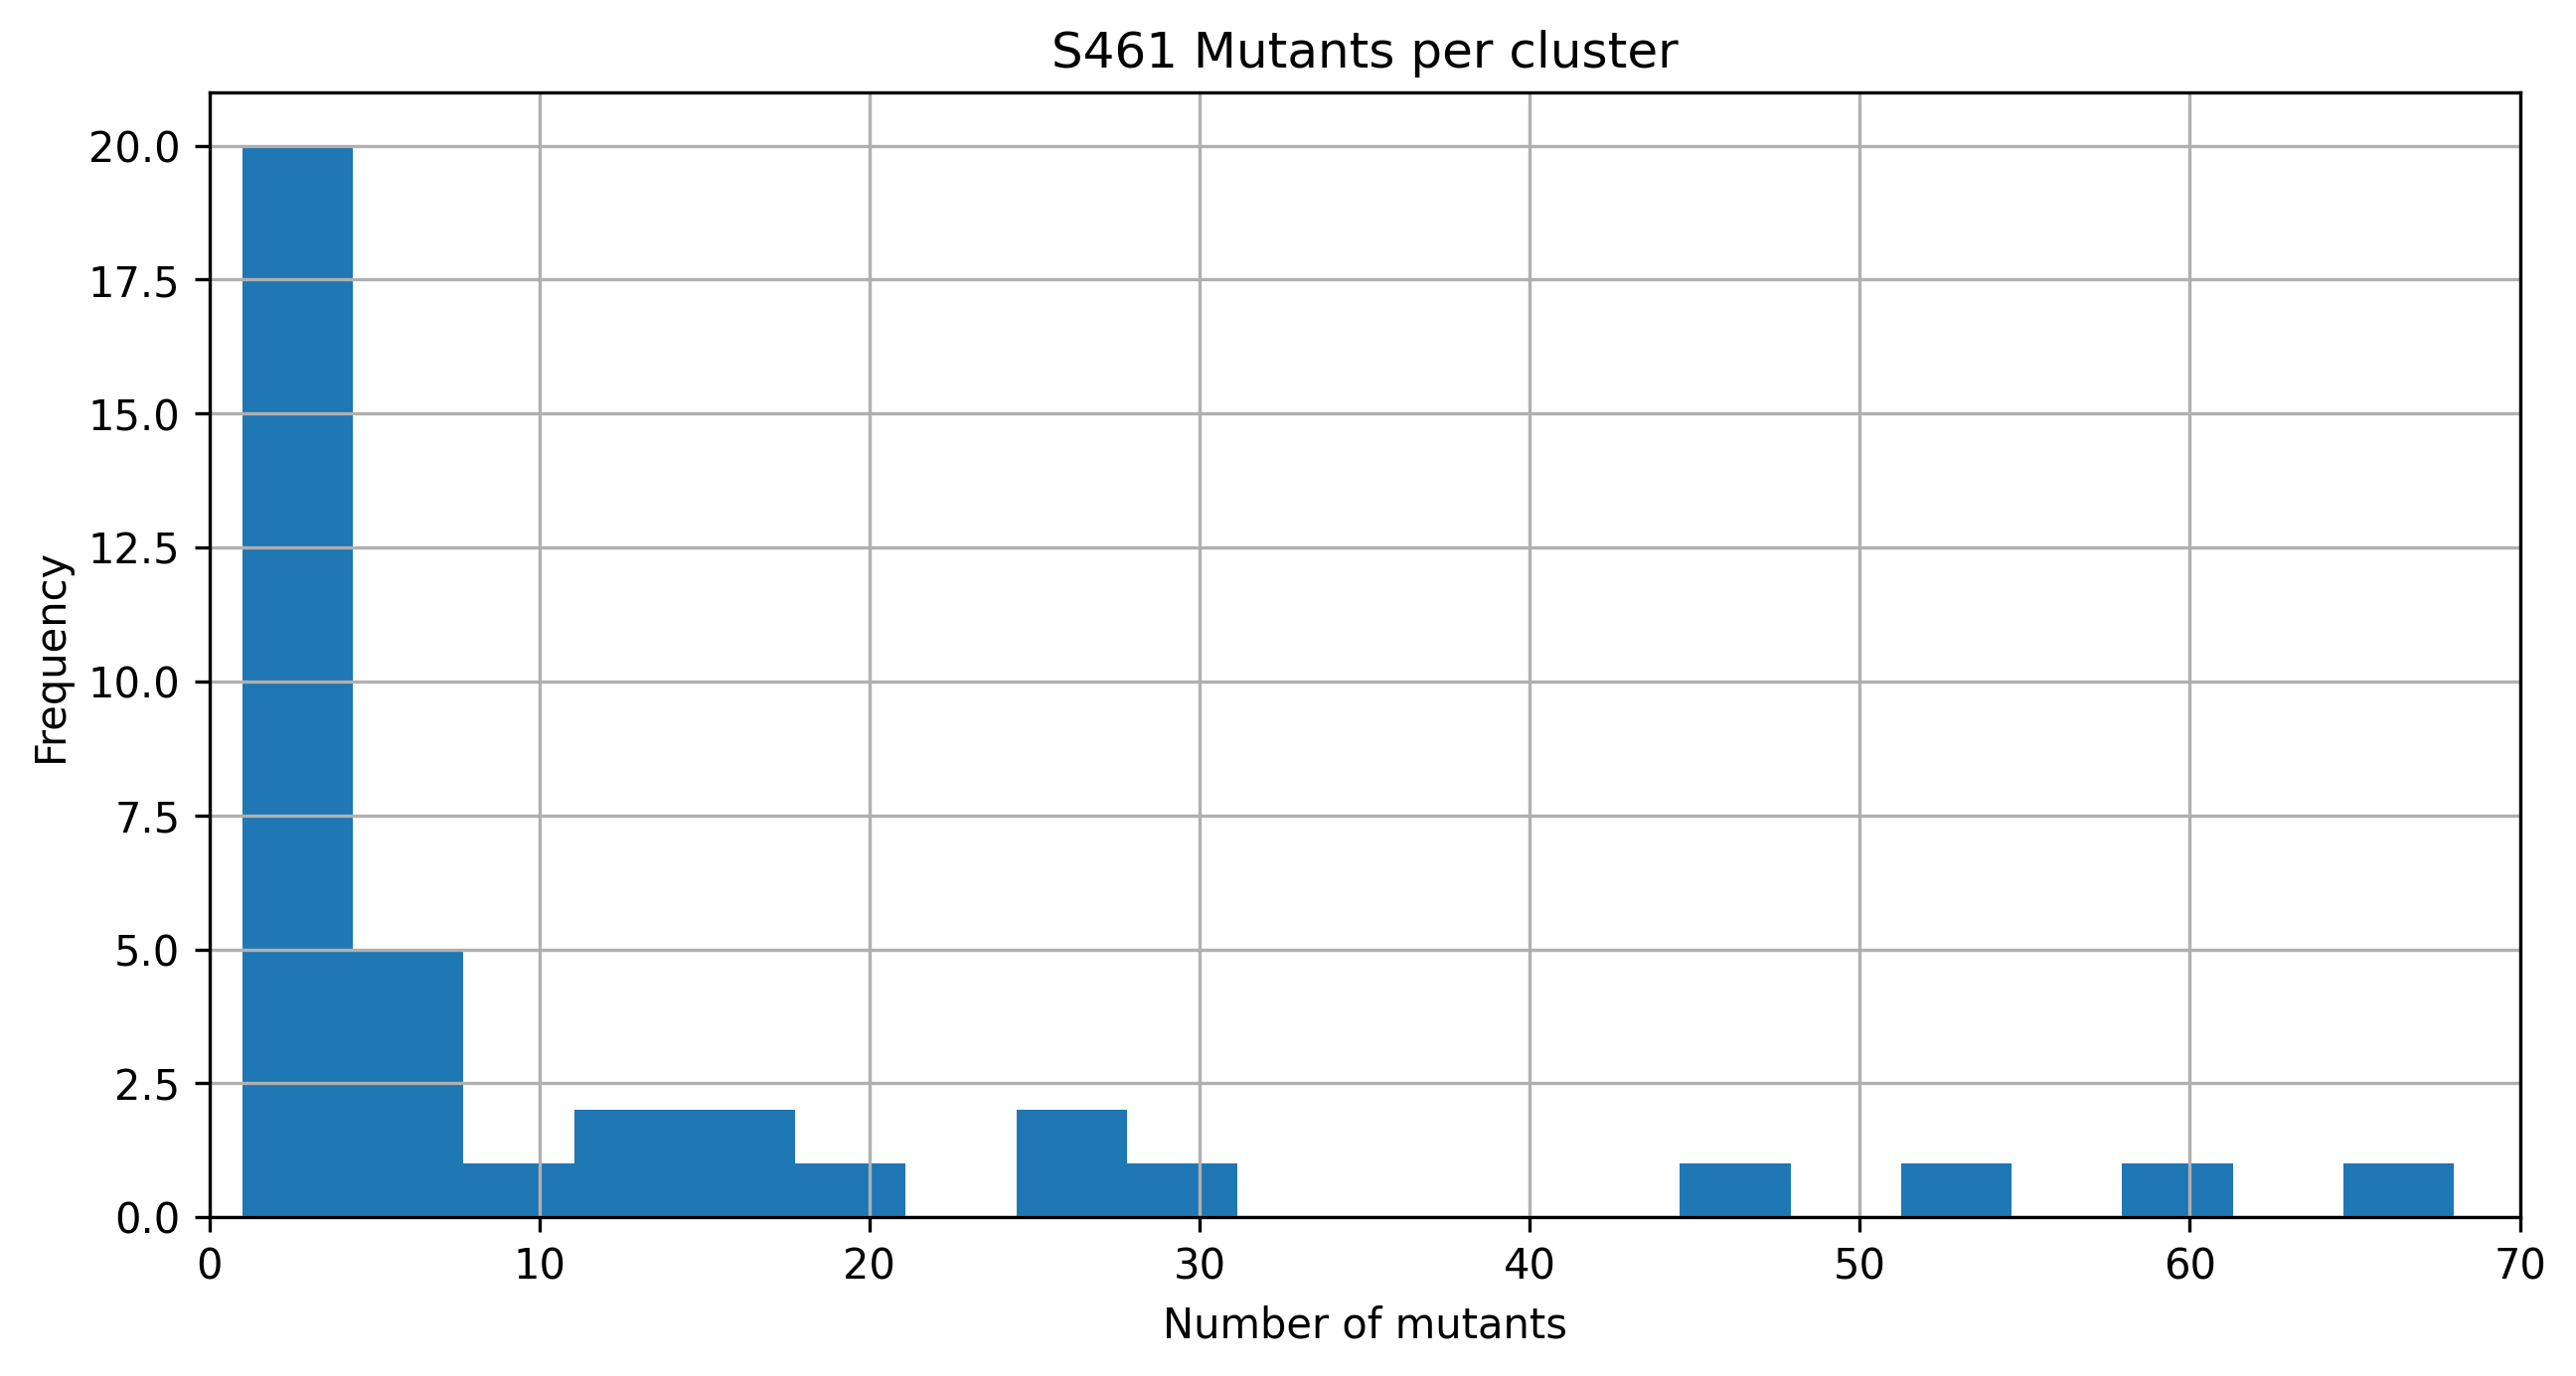

In [25]:
db_class = db_preds.join(db_clusters).join(db_ddg).reset_index().set_index(['uid', 'uid2'])

db_class = db_class[original_pred_cols_reduced + ['ddG_dir', 'cluster']]

#db_class['ens_dir'] = db_class['mpnn_20_00_dir'] + db_class['cartesian_ddg_dir']

evolutionary = ['tranception', 'msa_transformer', 'esm1v', 'msa', 'esm2', 'ankh']
structural = ['mpnn', 'mif', 'esmif', 'mutcomputex']
supervised = ['MAESTRO', 'ThermoNet', 'INPS', 'PremPS', 'mCSM', 'DUET', 'ACDC', 'I-Mutant3.0', 'SAAFEC', 'MuPro']
untrained = ['DDGun']
potential = ['KORPM', 'PopMusic', 'SDM']
biophysical = ['cartesian_ddg', 'FoldX', 'Evo']

db_class_rescaled = db_class.copy(deep=True)
db_class_rescaled[original_pred_cols_reduced] /= db_class_rescaled[original_pred_cols_reduced].std()

db_class['structural_dir'] = db_class_rescaled[[c for c in db_class.columns if any([s in c for s in structural])]].mean(axis=1)
db_class['evolutionary_dir'] = db_class_rescaled[[c for c in db_class.columns if any([s in c for s in evolutionary])]].mean(axis=1)
db_class['supervised_dir'] = db_class[[c for c in db_class.columns if any([s in c for s in supervised])]].mean(axis=1)
db_class['potential_dir'] = db_class[[c for c in db_class.columns if any([s in c for s in potential])]].mean(axis=1)
db_class['biophysical_dir'] = db_class[[c for c in db_class.columns if any([s in c for s in biophysical])]].mean(axis=1)
db_class['mpnn_rosetta_dir'] = db_class['cartesian_ddg_dir'] + db_class['mpnn_20_00_dir']
db_class['mpnn_oracle_dir'] = db_class['stability-oracle_dir'] + db_class['mpnn_20_00_dir']

db_class['mpnn_mean_dir'] = db_class[['mpnn_10_00_dir', 'mpnn_20_00_dir', 'mpnn_30_00_dir']].mean(axis=1)
#db_class['runtime_mpnn_mean_dir'] = db_class[['runtime_mpnn_10_00_dir', 'runtime_mpnn_20_00_dir', 'runtime_mpnn_30_00_dir']].sum(axis=1)

db_class['esmif_mean_dir'] = db_class[['esmif_multimer_dir', 'esmif_monomer_dir']].mean(axis=1)
#db_class['runtime_esmif_mean_dir'] = db_class[['runtime_esmif_multimer_dir', 'runtime_esmif_monomer_dir']].sum(axis=1)

db_class['mif_mean_dir'] = db_class[['mif_dir', 'mifst_dir']].mean(axis=1)
#db_class['runtime_mif_mean_dir'] = db_class[['runtime_mif_dir', 'runtime_mifst_dir']].sum(axis=1)

db_class['esm2_mean_dir'] = db_class[['esm2_15B_half_dir', 'esm2_dir', 'esm2_650M_dir', 'esm2_150M_dir']].mean(axis=1)
#db_class['runtime_esm2_mean_dir'] = db_class[['runtime_esm2_15B_half_dir', 'runtime_esm2_dir', 'runtime_esm2_650M_dir', 'runtime_esm2_150M_dir']].sum(axis=1)

db_class['random_dir'] = np.random.rand(len(db_class)) - 0.5
db_class['random_inv'] = np.random.rand(len(db_class)) - 0.5

db_class = db_class.drop([c+'_dir' for c in ['ACDCNND', 'FoldXD', 'DDGunD', 'PopMsD', 'CartddgD', 'TNetD']], axis=1)
db_class['korpm_dir'] = db_class['KORPMD_dir']

db_class = db_class.join(db_feats_2[['delta_kdh', 'delta_vol', 'rel_ASA']])

print(f'Detected {len(db_class.loc[db_feats_2["on_interface"].astype(bool)])} interface mutations')

db_class.to_csv(preds_loc.replace('preds.csv', 'preds_clusters_extra.csv'))
fig, axes = plt.subplots(1, figsize=(10, 5), dpi=300) 
db_class.groupby('cluster').count().iloc[:, 0].hist(bins=20, ax=axes)
#db_class.groupby('cluster').count().iloc[:, 0].hist(bins=800, ax=axes[1])
plt.xlim([0,70])
plt.title('S461 Mutants per cluster')
plt.xlabel('Number of mutants')
plt.ylabel('Frequency')

db_class

In [18]:
db_class.groupby('cluster').count().iloc[:, [1]]

EvoD_dir
cluster          
1              16
2               1
3              29
4              26
5               2
6               1
7              20
8              68
9              17
10              5
11             27
12              8
13              6
14              3
15              6
16             61
17              1
18              6
19              3
20              2
21             12
22             52
23              2
24              1
25              2
26              4
27              1
28             13
29              2
30              1
31              1
32              5
33             46
34              2
35              2
36              4
37              1
38              2

In [7]:
print((db_class.groupby('cluster').count().iloc[:, 0] >= 10).sum(), (db_class.groupby('cluster').count().iloc[:, 0] < 10).sum())

12 26


In [8]:
db_class = pd.read_csv(preds_loc.replace('preds.csv', 'preds_clusters_extra.csv'))
db_class = db_class.set_index(['uid', 'uid2'])
db_class['ddG'] = db_class['ddG_dir']
db_class = db_class.rename(dict(zip([f'e{i}_transfer' for i in range(5)], [f'e{i}_transfer_dir' for i in range(5)])), axis=1)

In [9]:
db_class

KORPMD_dir  EvoD_dir  Dyna2D_dir  ACDC-NN-Seq_dir  \
uid       uid2                                                           
1A0F_11A  1A0F_11A        0.138     -0.37       0.545         0.041723   
1BA3_461D 1BA3_457D      -1.065     -0.77       0.160        -0.447964   
1BA3_489D 1BA3_485D       0.270      0.96      -0.193        -0.000271   
1BA3_489K 1BA3_485K       0.398      1.12       0.190         0.006583   
1BA3_489M 1BA3_485M      -0.211      1.42      -0.138         0.079617   
...                         ...       ...         ...              ...   
4HE7_19G  4HE7_19G       -0.249     -0.71      -0.133        -0.914432   
4HE7_19K  4HE7_19K       -0.063      0.18      -0.119         0.026103   
5JXB_329G 5JXB_25G       -0.426     -0.53       0.694        -0.000839   
5JXB_329P 5JXB_25P       -0.930      0.42       0.390         0.000536   
5OAQ_429H 5OAQ_199H      -2.512     -4.12      -0.411        -1.387815   

                     ACDC-NN_dir  DDG_checked_dir  DDGun3D_dir  DDGun_dir  \
uid       uid2                                                              
1A0F_11A  1A0F_11A      0.225406           -1.800          0.5        0.0   
1BA3_461D 1BA3_457D    -0.230352           -1.745         -1.2       -1.4   
1BA3_489D 1BA3_485D    -0.040138            0.287         -0.1       -0.7   
1BA3_489K 1BA3_485K     0.201055           -0.287         -0.1       -0.9   
1BA3_489M 1BA3_485M     0.230963           -0.263          0.0        0.0   
...                          ...              ...          ...        ...   
4HE7_19G  4HE7_19G     -0.728433            0.060         -0.4       -1.3   
4HE7_19K  4HE7_19K     -0.345831           -0.460         -0.3       -1.1   
5JXB_329G 5JXB_25G     -0.134107           -1.440         -0.3       -0.7   
5JXB_329P 5JXB_25P      0.134216           -1.440         -0.2       -0.4   
5OAQ_429H 5OAQ_199H    -1.356237           -2.990         -2.4       -2.7   

                     DUET_dir  Dynamut_dir  ...  mpnn_mean_dir  \
uid       uid2                              ...                  
1A0F_11A  1A0F_11A     -0.466        0.545  ...      -2.161944   
1BA3_461D 1BA3_457D    -1.757        0.160  ...      -3.510182   
1BA3_489D 1BA3_485D    -0.252       -0.193  ...       1.273798   
1BA3_489K 1BA3_485K     0.358        0.190  ...       2.673919   
1BA3_489M 1BA3_485M     0.287       -0.138  ...      -0.743079   
...                       ...          ...  ...            ...   
4HE7_19G  4HE7_19G     -0.021       -0.133  ...      -1.266505   
4HE7_19K  4HE7_19K     -0.518       -0.119  ...       0.740787   
5JXB_329G 5JXB_25G      0.254        0.694  ...      -0.822337   
5JXB_329P 5JXB_25P      0.362        0.390  ...      -3.261567   
5OAQ_429H 5OAQ_199H    -1.531       -0.411  ...      -5.448292   

                     esmif_mean_dir  mif_mean_dir  esm2_mean_dir  random_dir  \
uid       uid2                                                                 
1A0F_11A  1A0F_11A        -0.018018     -6.962128      -6.578033   -0.453501   
1BA3_461D 1BA3_457D       -0.011513     -5.899839      -6.044271   -0.435916   
1BA3_489D 1BA3_485D        0.004294      1.124316      -0.746243    0.028025   
1BA3_489K 1BA3_485K        0.005098      2.702672       2.660306   -0.021463   
1BA3_489M 1BA3_485M       -0.004893     -2.323266      -3.853504    0.272995   
...                             ...           ...            ...         ...   
4HE7_19G  4HE7_19G        -0.046678     -3.463819      -0.016662   -0.371489   
4HE7_19K  4HE7_19K         0.024325      0.419811       0.577011   -0.465075   
5JXB_329G 5JXB_25G        -0.015747     -5.737733      -8.416318    0.420110   
5JXB_329P 5JXB_25P        -0.033224     -9.912117     -12.735922   -0.490337   
5OAQ_429H 5OAQ_199H       -0.033104     -6.807974      -4.900617   -0.264645   

                     random_inv  delta_kdh  delta_vol   rel_ASA    ddG  
uid       uid2                                                          
1A0F_11A  

In [10]:
class_result = analysis_utils.compute_stats(db_class, stats=(), measurements=['ddG'], grouper='cluster', n_bootstraps=0)
tmp1 = class_result #.loc[:,['n', 'MCC', 'auprc', 'spearman', 'weighted_ndcg', 'weighted_auprc', 'weighted_spearman']]
tmp = tmp1.sort_values(['measurement', 'weighted_spearman'], ascending=False).reset_index()


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

In [11]:
tmp = tmp1.sort_values(['measurement', 'weighted_spearman'], ascending=False).reset_index()

for source, target in remap_names_2.items():
    tmp.loc[tmp['model']==source, 'model'] = target
#tmp['model'] = tmp['model'].map(remap_names)
tmp.loc[tmp['model'].isin(['Gaussian noise', 'ΔΔG', 'ΔTm']), 'model_type'] = 'N/A'

remap_cols = {'auprc': 'AUPRC', 'spearman': 'ρ', 'auppc': 'mean PPC', 'aumsc': 'mean MSC', 'weighted_ndcg': 'wNDCG', 
    'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC', 'tp': 'True Positives', 'sensitivity': 'Sensitivity', 
    'net_stabilization': 'Net Stabilization', 'accuracy': 'Accuracy'}
tmp = tmp.rename(remap_cols, axis=1)
tmp = tmp[['measurement', 'model_type', 'model', 'n', 'MCC', 'AUPRC', 'ρ', 'wNDCG', 'wAUPRC', 'wρ', 'mean_t1s', 'Net Stabilization',
    'mean_stabilization', 'mean PPC', 'mean MSC', 'True Positives', 'Sensitivity', 'Accuracy']]
#tmp = tmp.loc[tmp['model'].isin(['Rosetta_CartDDG', 'ProteinMPNN_mean', 'ProteinMPNN_30', 'ProteinMPNN_20', 'ESM-IF', 'MIF', 'ESM-IF(M)', 'Ankh', 
#    'ESM-2_3B', 'ESM-2_15B', 'Structural', 'Evolutionary', 'Supervised', 'ESM-2_150M', 'ESM-2_650M', 'Ensemble', 'ESM-2_mean', 'ESM-IF_mean', 
#    'MIF_mean', 'Clustered_Ensemble', 'Ensemble_2', 'ProteinMPNN_10', 'MIF-ST', 'KORPM', 'MSA-T_mean', 'MSA-T_1', 'Tranception', 'ESM-1V_mean', 
#    'ESM-1V_2', 'Gaussian noise', 'ΔΔG label', 'ΔTm label', 'ProteinMPNN + Rosetta_CartDDG'])]
tmp = tmp.dropna(subset='model').set_index(['measurement', 'model_type', 'model']).astype(float).round(3)
tmp

n    MCC  \
measurement model_type   model                                             
ddG         unknown      ΔΔG label                          461.0  1.000   
            NaN          DDG_checked_dir                    461.0  0.910   
            transfer     Stability Oracle                   460.0  0.359   
            structural   mpnn_oracle_dir                    460.0  0.299   
                         ProteinMPNN 0.2 + Rosetta CartDDG  461.0  0.331   
            biophysical  Rosetta CartDDG                    461.0  0.307   
            NaN          biophysical_dir                    461.0  0.314   
            potential    KORPMD_dir                         461.0  0.300   
                         KORPM                              461.0  0.300   
            NaN          Structural                         461.0  0.227   
            supervised   INPS3D_dir                         461.0  0.203   
            structural   ESM-IF(M)                          461.0  0.202   
            NaN          potential_dir                      461.0  0.322   
            structural   ESM-IF mean                        461.0  0.207   
            supervised   MAESTRO_dir                        461.0  0.315   
            structural   ProteinMPNN mean                   461.0  0.240   
                         ProteinMPNN 0.2                    461.0  0.316   
                         ESM-IF                             461.0  0.207   
                         ProteinMPNN 0.3                    461.0  0.247   
                         MIF-ST                             461.0  0.258   
            supervised   PremPS_dir                         461.0  0.179   
            structural   MIF mean                           461.0  0.225   
                         ProteinMPNN 0.1                    461.0  0.264   
            untrained    DDGun_dir                          434.0  0.327   
            structural   MIF                                461.0  0.272   
            NaN          Supervised                         461.0  0.146   
            structural   MutComputeX                        461.0  0.179   
            supervised   INPS-Seq_dir                       461.0  0.248   
            NaN          Evolutionary                       461.0  0.179   
            transfer     ACDC-NN_dir                        461.0  0.183   
            evolutionary Tranception                        461.0  0.190   
            potential    PopMusic_dir                       461.0  0.267   
            evolutionary Ankh                               461.0  0.208   
            supervised   DUET_dir                           461.0  0.241   
            evolutionary ESM-2 15B                          461.0  0.239   
            untrained    DDGun3D_dir                        461.0  0.315   
            biophysical  FoldX_dir                          461.0  0.153   
            evolutionary ESM-2 mean                         461.0  0.156   
                         ESM-1V mean                        461.0  0.300   
                         ESM-2 650M                         461.0  0.231   
            supervised   ThermoNet_dir                      461.0  0.182   
            evolutionary ESM-1V median                      461.0  0.312   
            supervised   I-Mutant3.0_dir                    461.0  0.126   
                         SAAFEC-Seq_dir                     461.0  0.126   
            transfer     ACDC-NN-Seq_dir                    461.0  0.185   
            supervised   mCSM_dir                           461.0  0.098   
            evolutionary ESM-2 3B                           461.0  0.131   
                         ESM-2 150M                         461.0  0.208   
            potential    SDM_dir                            461.0  0.267   
            evolutionary MSA-T median                       461.0  0.139   
                         MSA-T mean                         461.0  0.132   
            supervised   MuPro_dir  

In [12]:
tmp.xs('ddG').sort_values('ρ', ascending=False).reset_index()[['model_type', 'model', 'ρ', 'AUPRC', 'wNDCG', 'mean_stabilization', 'mean_t1s', 'Sensitivity']]

model_type                              model      ρ  AUPRC  wNDCG  \
0        unknown                          ΔΔG label  1.000  1.000  1.000   
1            NaN                    DDG_checked_dir  0.978  0.849  0.998   
2       transfer                   Stability Oracle  0.651  0.417  0.715   
3            NaN                      potential_dir  0.644  0.435  0.674   
4     structural  ProteinMPNN 0.2 + Rosetta CartDDG  0.636  0.492  0.760   
5    biophysical                    Rosetta CartDDG  0.620  0.470  0.659   
6            NaN                         Supervised  0.605  0.365  0.662   
7     supervised                         PremPS_dir  0.604  0.329  0.597   
8      potential                       PopMusic_dir  0.602  0.355  0.588   
9     supervised                        MAESTRO_dir  0.599  0.347  0.591   
10    supervised                         INPS3D_dir  0.592  0.327  0.649   
11     untrained                        DDGun3D_dir  0.577  0.364  0.644   
12    supervised                           DUET_dir  0.571  0.306  0.632   
13     untrained                          DDGun_dir  0.571  0.386  0.691   
14           NaN                    biophysical_dir  0.570  0.399  0.648   
15      transfer                        ACDC-NN_dir  0.564  0.355  0.656   
16    structural                    mpnn_oracle_dir  0.560  0.401  0.690   
17     potential                              KORPM  0.544  0.386  0.687   
18     potential                         KORPMD_dir  0.544  0.386  0.687   
19    supervised                       INPS-Seq_dir  0.543  0.357  0.639   
20      transfer                    ACDC-NN-Seq_dir  0.537  0.304  0.620   
21    supervised                           mCSM_dir  0.514  0.263  0.555   
22     potential                            SDM_dir  0.513  0.344  0.618   
23    supervised                      ThermoNet_dir  0.483  0.283  0.573   
24    supervised                     SAAFEC-Seq_dir  0.471  0.278  0.628   
25    supervised                    I-Mutant3.0_dir  0.471  0.278  0.628   
26           NaN                         Structural  0.462  0.353  0.666   
27   biophysical                           EvoD_dir  0.462  0.276  0.575   
28    structural                                MIF  0.461  0.385  0.614   
29  evolutionary                               Ankh  0.444  0.308  0.623   
30    supervised                I-Mutant3.0-Seq_dir  0.443  0.257  0.605   
31  evolutionary                         ESM-2 650M  0.442  0.325  0.666   
32    structural                    ProteinMPNN 0.3  0.440  0.300  0.629   
33    structural                           MIF mean  0.439  0.366  0.722   
34    structural                    ProteinMPNN 0.2  0.436  0.324  0.634   
35           NaN                         Dyna2D_dir  0.435  0.235  0.516   
36       unknown                        Dynamut_dir  0.435  0.235  0.516   
37    structural                   ProteinMPNN mean  0.432  0.314  0.671   
38           NaN                       Evolutionary  0.430  0.329  0.646   
39  evolutionary                        ESM-1V mean  0.429  0.390  0.685   
40    structural                          ESM-IF(M)  0.429  0.348  0.651   
41  evolutionary                      ESM-1V median  0.422  0.386  0.692   
42    structural                        ESM-IF mean  0.419  0.344  0.653   
43  evolutionary                         ESM-2 mean  0.411  0.325  0.632   
44    structural                             ESM-IF  0.407  0.340  0.637   
45    structural                    ProteinMPNN 0.1  0.395  0.295  0.619   
46  evolutionary                         ESM-2 150M  0.394  0.330  0.619   
47    structural                             MIF-ST  0.377  0.340  0.713   
48  evolutionary                           ESM-2 3B  0.364  0.297  0.611   
49    structural                        MutComputeX  0.364  0.252  0.566   
50    supervised                          MuPro_dir  0.358  0.263  0.546   
51   biophysical                          FoldX_dir  0

In [13]:
# NOTE: The columns ending in % refer to the percentile-precition curve. The ones ending with $ refer to the percentile mean stability curve.
class_result[['n', 'MCC', 'auprc', 'spearman', 'weighted_ndcg', 'weighted_auprc', 'weighted_spearman', 'auppc', 'aumsc', '90%', '90$', 'net_stabilization', 'mean_stabilization', 'mean_t1s', 'pred_positives']].sort_values('aumsc', ascending=False)

n       MCC  \
measurement model_type   model                      class                    
ddG         unknown      ddG_dir                           461.0  1.000000   
            NaN          DDG_checked_dir                   461.0  0.910197   
            structural   mpnn_rosetta_dir                  461.0  0.331397   
            transfer     stability-oracle_dir              460.0  0.358882   
            structural   mpnn_oracle_dir                   460.0  0.298980   
            supervised   INPS3D_dir                        461.0  0.202880   
            NaN          potential_dir                     461.0  0.322288   
            biophysical  cartesian_ddg_dir                 461.0  0.307011   
            supervised   PremPS_dir                        461.0  0.178962   
            NaN          supervised_dir                    461.0  0.146224   
            supervised   MAESTRO_dir                       461.0  0.314734   
            NaN          biophysical_dir                   461.0  0.314057   
                         structural_dir                    461.0  0.226954   
            structural   esmif_monomer_dir                 461.0  0.202314   
                         esmif_mean_dir                    461.0  0.207317   
                         mif_mean_dir                      461.0  0.225140   
            transfer     ACDC-NN_dir                       461.0  0.182807   
            supervised   INPS-Seq_dir                      461.0  0.248497   
            potential    KORPMD_dir                        461.0  0.299678   
                         korpm_dir                         461.0  0.299678   
            NaN          evolutionary_dir                  461.0  0.179085   
            untrained    DDGun_dir                         434.0  0.327079   
            structural   mpnn_20_00_dir                    461.0  0.316410   
            untrained    DDGun3D_dir                       461.0  0.314972   
            structural   esmif_multimer_dir                461.0  0.207317   
            evolutionary esm2_mean_dir                     461.0  0.156141   
            structural   mif_dir                           461.0  0.271987   
                         mpnn_mean_dir                     461.0  0.239647   
                         mifst_dir                         461.0  0.257745   
            evolutionary esm2_650M_dir                     461.0  0.231119   
            potential    PopMusic_dir                      461.0  0.266973   
            transfer     ACDC-NN-Seq_dir                   461.0  0.185404   
            supervised   I-Mutant3.0_dir                   461.0  0.126456   
                         SAAFEC-Seq_dir                    461.0  0.126456   
            evolutionary esm1v_mean_dir                    461.0  0.299588   
                         ankh_dir                          461.0  0.208216   
                         esm1v_median_dir                  461.0  0.311572   
            supervised   DUET_dir                          461.0  0.240554   
            structural   mpnn_10_00_dir                    461.0  0.263848   
                         mpnn_30_00_dir                    461.0  0.247362   
            evolutionary esm2_15B_half_dir                 461.0  0.239413   
                         esm2_dir                          461.0  0.131103   
            supervised   ThermoNet_dir                     461.0  0.182021   
            evolutionary esm2_150M_dir                     461.0  0.207996   
                         tranception_dir                   461.0  0.190202   
            biophysical  EvoD_dir                          461.0  0.192213   
            supervised   mCSM_dir                          461.0  0.098490   
            structural   mutcomputex_dir                   461.0  0.178960   
            potential    SDM_dir                           461.0  0.267444   
            supervised   I-Mutant3.0-Seq_dir               461.0  0.151752   
       

In [14]:
import importlib
importlib.reload(analysis_utils)
summ = analysis_utils.compute_stats(db_class.reset_index('uid2', drop=True), 
                                    stats=('n', 'MCC', 'pred_positives', 'tp', 'auprc', 'spearman', 'ndcg', 'mean_t1s', 'mean_stabilization', 'net_stabilization', 'sensitivity', 'recall@k0.0', 'recall@k1.0', 'mean_reciprocal_rank'), 
                                    measurements=['ddG'], grouper='cluster', n_classes=2, n_bootstraps=100, quiet=True)
tmp1 = summ.reset_index()

In [15]:
remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

remap_cols = {'auprc': 'AUPRC', 'spearman': 'Spearman\'s ρ', 'auppc': 'mean PPC', 'aumsc': 'mean MSC', 'weighted_ndcg': 'wNDCG', 'ndcg': 'NDCG', 
    'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC', 'tp': 'True Positives', 'sensitivity': 'Sensitivity', 'mean_stabilization': 'Mean Stabilization',
    'net_stabilization': 'Net Stabilization', 'accuracy': 'Accuracy', 'mean_reciprocal_rank': 'MRR', 'n': 'n', 'MCC': 'MCC', 'recall@k1.0': 'Recall @ k'}

new_remap_cols = {}
for key, value in remap_cols.items():
    new_remap_cols[key + '_mean'] = value + ' mean'
    new_remap_cols[key + '_std'] = value + ' stdev'

s2 = summ.sort_values('net_stabilization_mean', ascending=False).dropna(how='all', axis=1).reset_index()
s3 = s2.loc[s2['model'].isin(original_pred_cols_reduced + ['random_dir', 'ddG_dir'])].drop('measurement', axis=1)
s4 = s3[['model_type', 'model',
    'recall@k1.0_mean', 'recall@k1.0_std',
    'ndcg_mean', 'ndcg_std', 
    'spearman_mean', 'spearman_std',
    'auprc_mean', 'auprc_std', 
    'MCC_mean', 'MCC_std', 
    'net_stabilization_mean', 'net_stabilization_std',
    ]]
s4['model'] = s4['model'].map(lambda x: remap_names_2.get(x, x[:-4]))
s5 = s4.set_index(['model_type', 'model'])
s5.columns = [new_remap_cols[c] for c in s5.columns]
s5
# Iterate over the DataFrame and update the mean columns
for column in s5.columns:
    if 'mean' in column:
        stdev_column = column.replace('mean', 'stdev')
        s5[column] = s5[column].round(3).astype(str) + ' ± ' + s5[stdev_column].round(2).astype(str)

# Drop the standard deviation columns
s5 = s5[[col for col in s5.columns if 'stdev' not in col]]
s5.columns = [col[:-5] for col in s5.columns]
s6 = s5.reset_index().rename({'model_type': 'Model Type', 'model': 'Model'}, axis=1)
s6

Model Type             Model    Recall @ k          NDCG  Spearman's ρ  \
0        unknown         ΔΔG label     1.0 ± 0.0     1.0 ± 0.0     1.0 ± 0.0   
1            NaN       DDG_checked  0.865 ± 0.13  0.975 ± 0.04  0.972 ± 0.05   
2   evolutionary         ESM-2 15B  0.261 ± 0.11  0.631 ± 0.08   0.316 ± 0.1   
3   evolutionary       Tranception  0.105 ± 0.08   0.51 ± 0.08   0.245 ± 0.1   
4   evolutionary      MSA-T median   0.19 ± 0.09   0.57 ± 0.08  0.202 ± 0.09   
5   evolutionary        ESM-2 650M   0.277 ± 0.1  0.608 ± 0.08  0.433 ± 0.09   
6   evolutionary     ESM-1V median  0.292 ± 0.11   0.641 ± 0.1   0.414 ± 0.1   
7   evolutionary        MSA-T mean   0.19 ± 0.09  0.565 ± 0.08  0.207 ± 0.08   
8   evolutionary       ESM-1V mean  0.292 ± 0.11  0.621 ± 0.09   0.421 ± 0.1   
9    biophysical   Rosetta CartDDG  0.242 ± 0.11   0.734 ± 0.1  0.596 ± 0.09   
10    supervised            PremPS  0.231 ± 0.13  0.698 ± 0.12   0.575 ± 0.1   
11  evolutionary              Ankh   0.185 ± 0.1   0.599 ± 0.1   0.435 ± 0.1   
12    supervised             MuPro  0.095 ± 0.08  0.498 ± 0.06  0.321 ± 0.12   
13    supervised            INPS3D  0.092 ± 0.08  0.518 ± 0.08  0.566 ± 0.08   
14  evolutionary          ESM-2 3B  0.192 ± 0.09  0.575 ± 0.09   0.352 ± 0.1   
15    structural            MIF-ST  0.234 ± 0.11  0.613 ± 0.09  0.372 ± 0.12   
16    supervised       I-Mutant3.0  0.117 ± 0.08  0.503 ± 0.05  0.442 ± 0.11   
17    supervised        SAAFEC-Seq  0.117 ± 0.08  0.503 ± 0.05  0.442 ± 0.11   
18    supervised          INPS-Seq  0.339 ± 0.14  0.618 ± 0.12  0.513 ± 0.09   
19     potential          PopMusic    0.1 ± 0.08  0.521 ± 0.06   0.58 ± 0.07   
20    structural            ESM-IF  0.125 ± 0.09  0.576 ± 0.11   0.396 ± 0.1   
21    supervised   I-Mutant3.0-Seq     0.0 ± 0.0  0.473 ± 0.05  0.402 ± 0.12   
22    supervised              mCSM  0.055 ± 0.07  0.465 ± 0.05    0.48 ± 0.1   
23    structural         ESM-IF(M)   0.157 ± 0.1  0.581 ± 0.11   0.416 ± 0.1   
24      transfer  Stability Oracle  0.155 ± 0.11   0.583 ± 0.1  0.632 ± 0.07   
25    supervised              DUET   0.061 ± 0.1  0.519 ± 0.06  0.544 ± 0.09   
26      transfer           ACDC-NN  0.202 ± 0.09  0.618 ± 0.11  0.532 ± 0.11   
27  evolutionary        ESM-2 150M   0.242 ± 0.1  0.622 ± 0.08  0.382 ± 0.09   
28    supervised           MAESTRO     0.0 ± 0.0  0.512 ± 0.06  0.581 ± 0.07   
29    structural   ProteinMPNN 0.2  0.276 ± 0.13  0.553 ± 0.07  0.416 ± 0.11   
30     untrained             DDGun  0.245 ± 0.11   0.751 ± 0.1  0.538 ± 0.11   
31      transfer       ACDC-NN-Seq  0.182 ± 0.09  0.553 ± 0.07  0.501 ± 0.11   
32    structural               MIF  0.281 ± 0.11  0.573 ± 0.06  0.441 ± 0.11   
33     untrained           DDGun3D  0.197 ± 0.11    0.72 ± 0.1  0.542 ± 0.11   
34    structural   ProteinMPNN 0.1  0.109 ± 0.09   0.52 ± 0.09  0.374 ± 0.12   
35    structural   ProteinMPNN 0.3  0.138 ± 0.11  0.545 ± 0.07  0.417 ± 0.11   
36     potential             KORPM  0.466 ± 0.09  0.765 ± 0.07  0.532 ± 0.09   
37     potential            KORPMD  0.466 ± 0.09  0.765 ± 0.07  0.532 ± 0.09   
38    structural       MutComputeX     0.0 ± 0.0  0.448 ± 0.06   0.348 ± 0.1   
39   biophysical              EvoD   0.189 ± 0.1  0.551 ± 0.06  0.433 ± 0.11   
40           NaN            Dyna2D   0.202 ± 0.1   0.64 ± 0.12  0.395 ± 0.11   
41       unknown           Dynamut   0.202 ± 0.1   0.64 ± 0.12  0.395 ± 0.11   
42     potential               SDM  0.178 ± 0.09  0.618 ± 0.08  0.496 ± 0.08   
43    supervised         ThermoNet  0.116 ± 0.11  0.595 ± 0.09   0.451 ± 0.1   
44   biophysical             FoldX   0.02 ± 0.07  0.489 ± 0.05  0.325 ± 0.14   
45       unknown    Gaussian Noise     0.0 ± 0.0  0.416 ± 0.04  0.013 ± 0.07   

           AUPRC            MCC  Net Stabilization  
0      1.0 ± 0.0      1.0 ± 0.0     72.718 ± 25.56  
1   0.872 ± 0.12   0.917 ± 0.08     59.086 ± 33.65  
2   0.343 ± 0.05   0.231 ± 0.06      6.981 ± 22.17  
3   0.257 ± 0.05   0.184 ± 0.05  

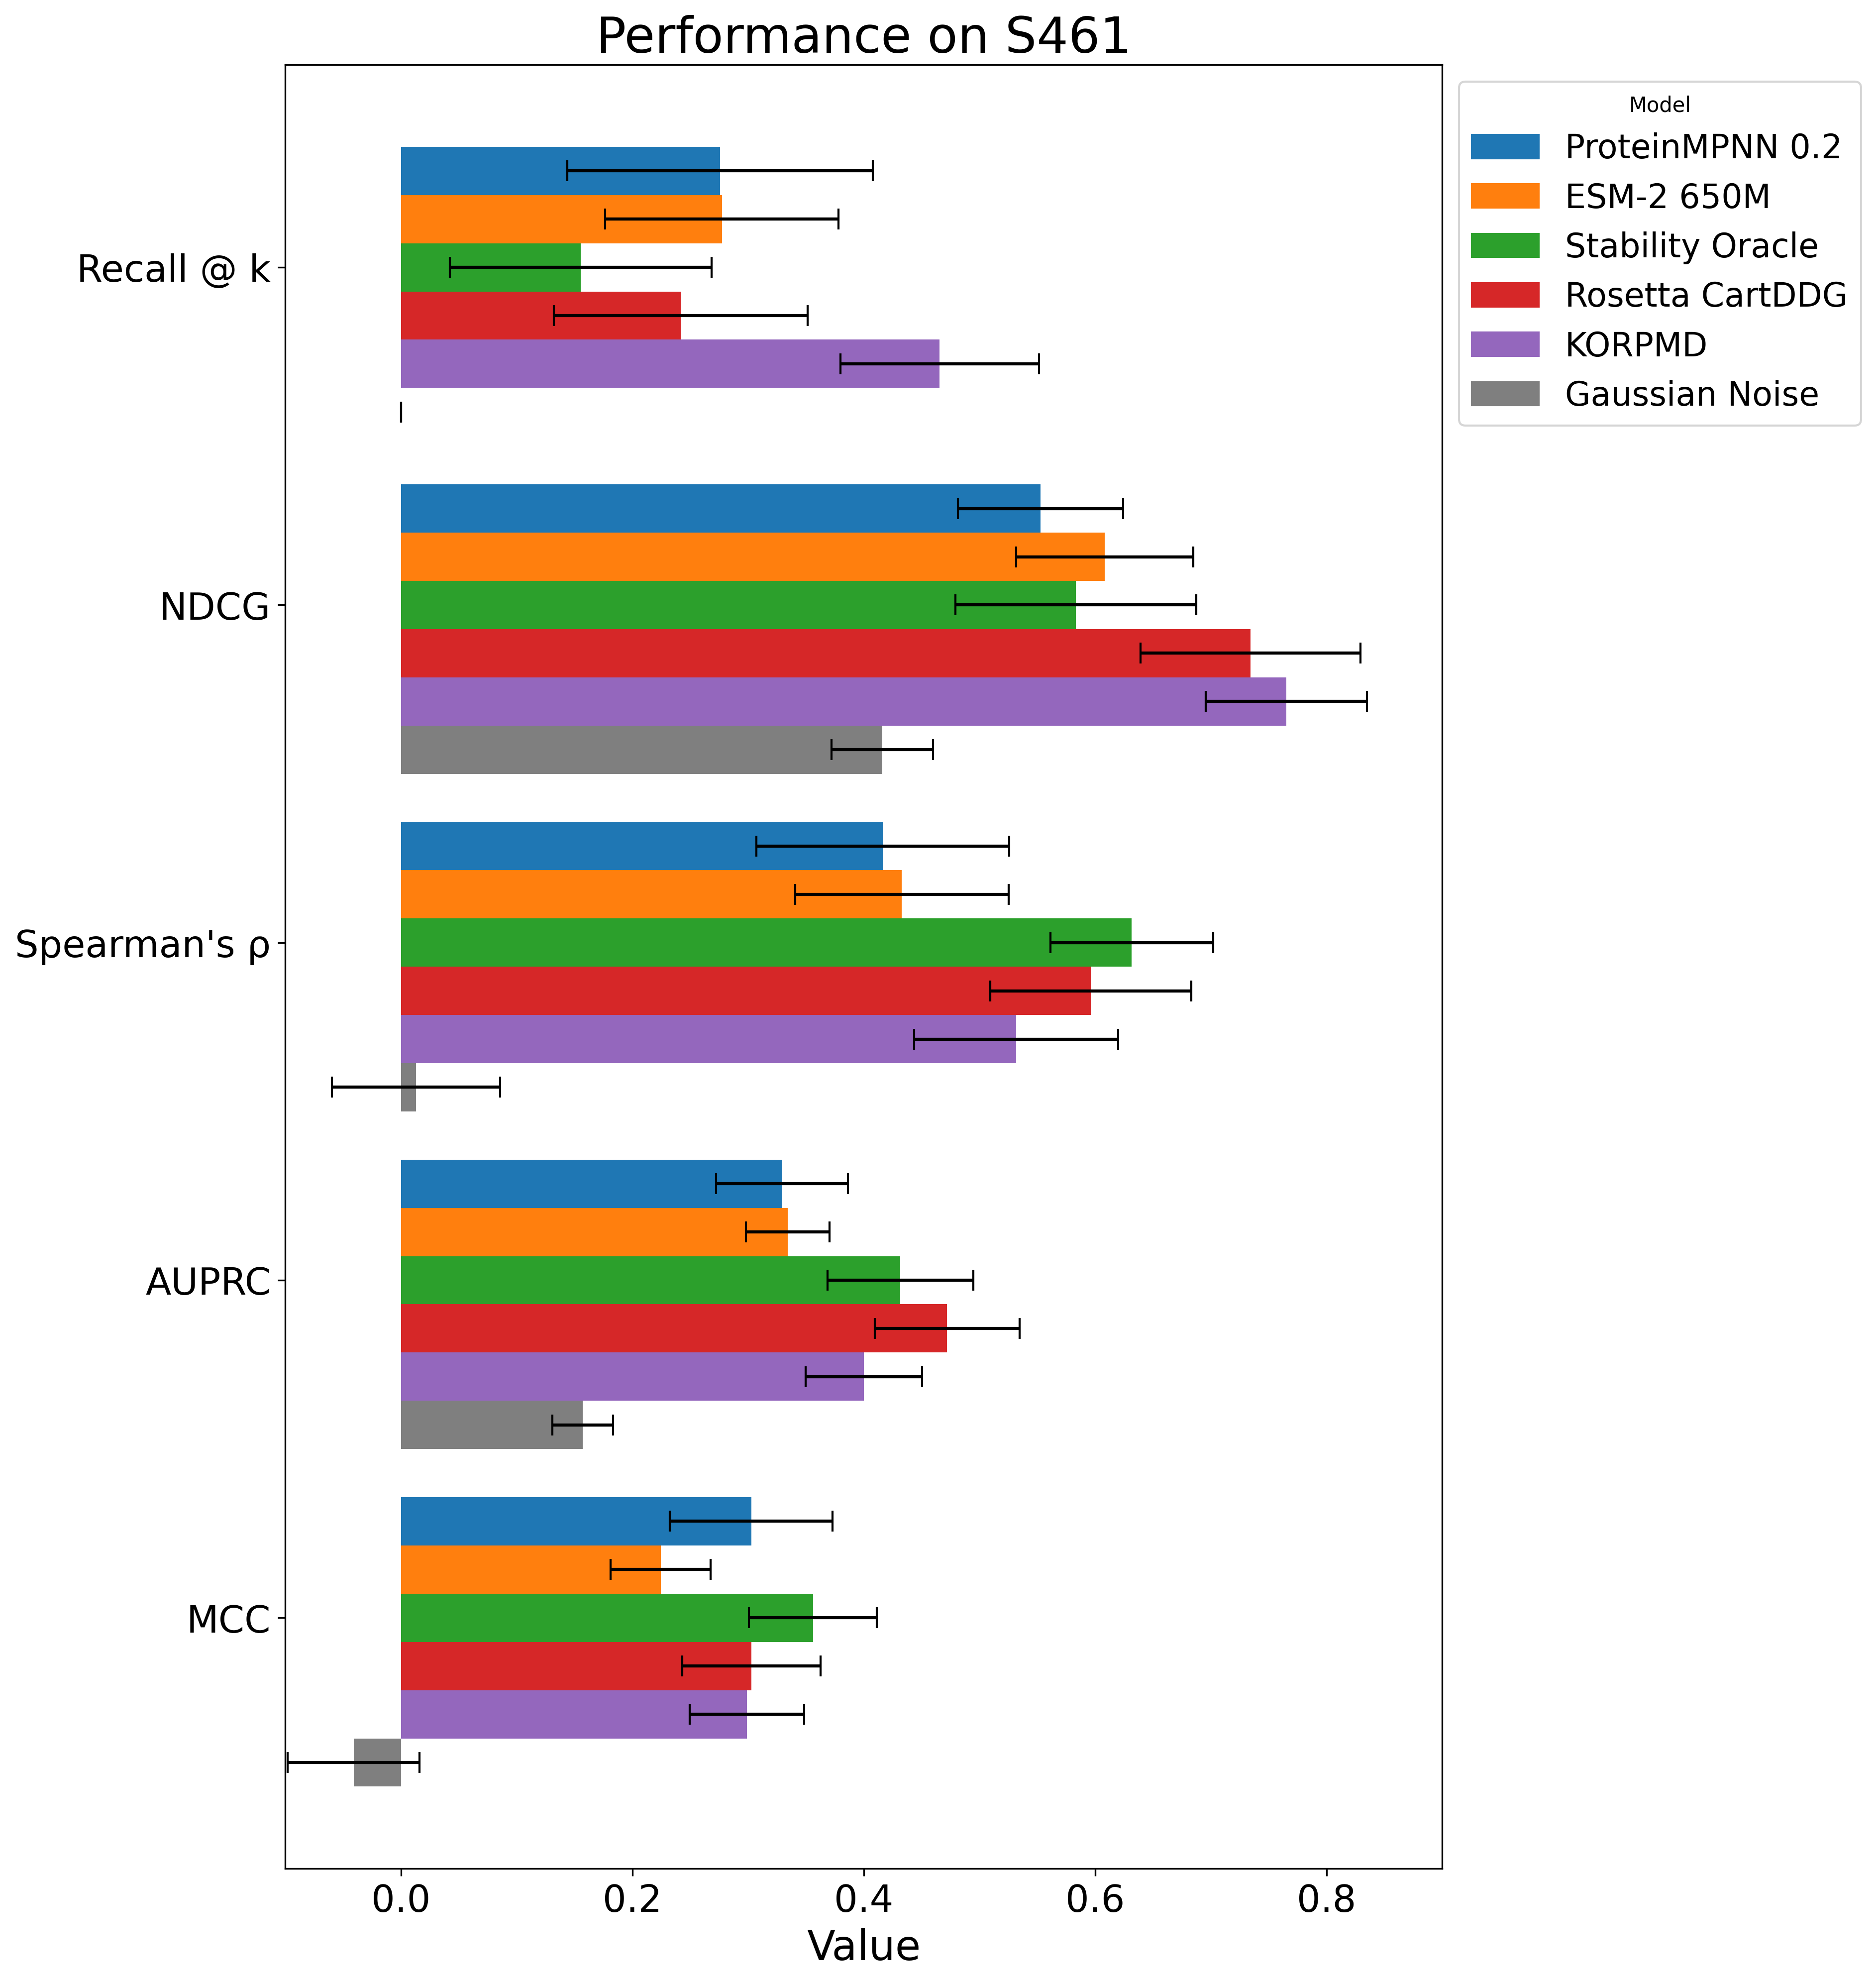

In [16]:
import importlib
importlib.reload(analysis_utils)

remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

tmp3 = tmp1.copy(deep=True)#.set_index('model')
#tmp3['fractional_gain_mean'] = tmp3['net_stabilization_mean'] / tmp3.at['ddG_dir', 'net_stabilization_mean']
#tmp3['fractional_gain_std'] = tmp3['net_stabilization_std'] / tmp3.at['ddG_dir', 'net_stabilization_mean']
#tmp3 = tmp3.reset_index()
#tmp3['fractional_gain_mean']

remap_cols = {'auprc': 'AUPRC', 'spearman': 'Spearman\'s ρ', 'auppc': 'mean PPC', 'aumsc': 'mean MSC', 'weighted_ndcg': 'wNDCG', 'ndcg': 'NDCG',
    'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC', 'tp': 'True Positives', 'sensitivity': 'Sensitivity', 'mean_stabilization': 'Mean Stabilization',
    'net_stabilization': 'Net Stabilization', 'accuracy': 'Accuracy', 'mean_reciprocal_rank': 'MRR', 'n': 'n', 'MCC': 'MCC', 'recall@k1.0': 'Recall @ k'}

new_remap_cols = {}
for key, value in remap_cols.items():
    new_remap_cols[key + '_mean'] = value + ' mean'
    new_remap_cols[key + '_std'] = value + ' stdev'

s2 = tmp3.sort_values('spearman_mean', ascending=False).dropna(how='all', axis=1).reset_index()
s4 = s2.loc[s2['model'].isin(original_pred_cols_reduced + ['random_dir', 'ddG_dir', 'mpnn_rosetta_dir'])]
#s4 = s3[['model', 'n_mean', 'MCC_mean', 'MCC_std', 'auprc_mean', 'auprc_std', 'spearman_mean', 'spearman_std', 'weighted_ndcg_mean', 'weighted_ndcg_std', 'recall@k1.0_mean', 'recall@k1.0_std', 'mean_stabilization_mean', 'mean_stabilization_std']]
#s4['model'] = s4['model'].map(lambda x: remap_names_2.get(x, x[:-4]))
s5 = s4

tmp2 = s5[[ 'model',  
            'MCC_mean', 'MCC_std',
            'auprc_mean', 'auprc_std',
            #'weighted_spearman_mean', 'weighted_spearman_std',
            'spearman_mean', 'spearman_std',
            #'weighted_ndcg_mean', 'weighted_ndcg_std',
            'ndcg_mean', 'ndcg_std',
            'recall@k1.0_mean', 'recall@k1.0_std', 
            ]].set_index('model')

tmp2.columns = [new_remap_cols[c] for c in tmp2.columns]
tmp2 = tmp2.reset_index().drop_duplicates()

#analysis_utils.make_bar_chart(tmp2, models=['ProteinMPNN 0.2', 'ESM-2 650M', 'Stability Oracle', 'Rosetta CartDDG', 'KORPM', 'DDGun3D', 'MAESTRO', 'Gaussian Noise'], title='Q3421', xlim=(-0.5, 0.8), figsize=(24, 16))
analysis_utils.make_bar_chart(tmp2, models=['mpnn_20_00', 'esm2_650M', 'stability-oracle', 'cartesian_ddg', 'KORPMD', 'random'], title='S461', xlim=(-0.1, 0.9), figsize=(10, 16))

KeyError: None

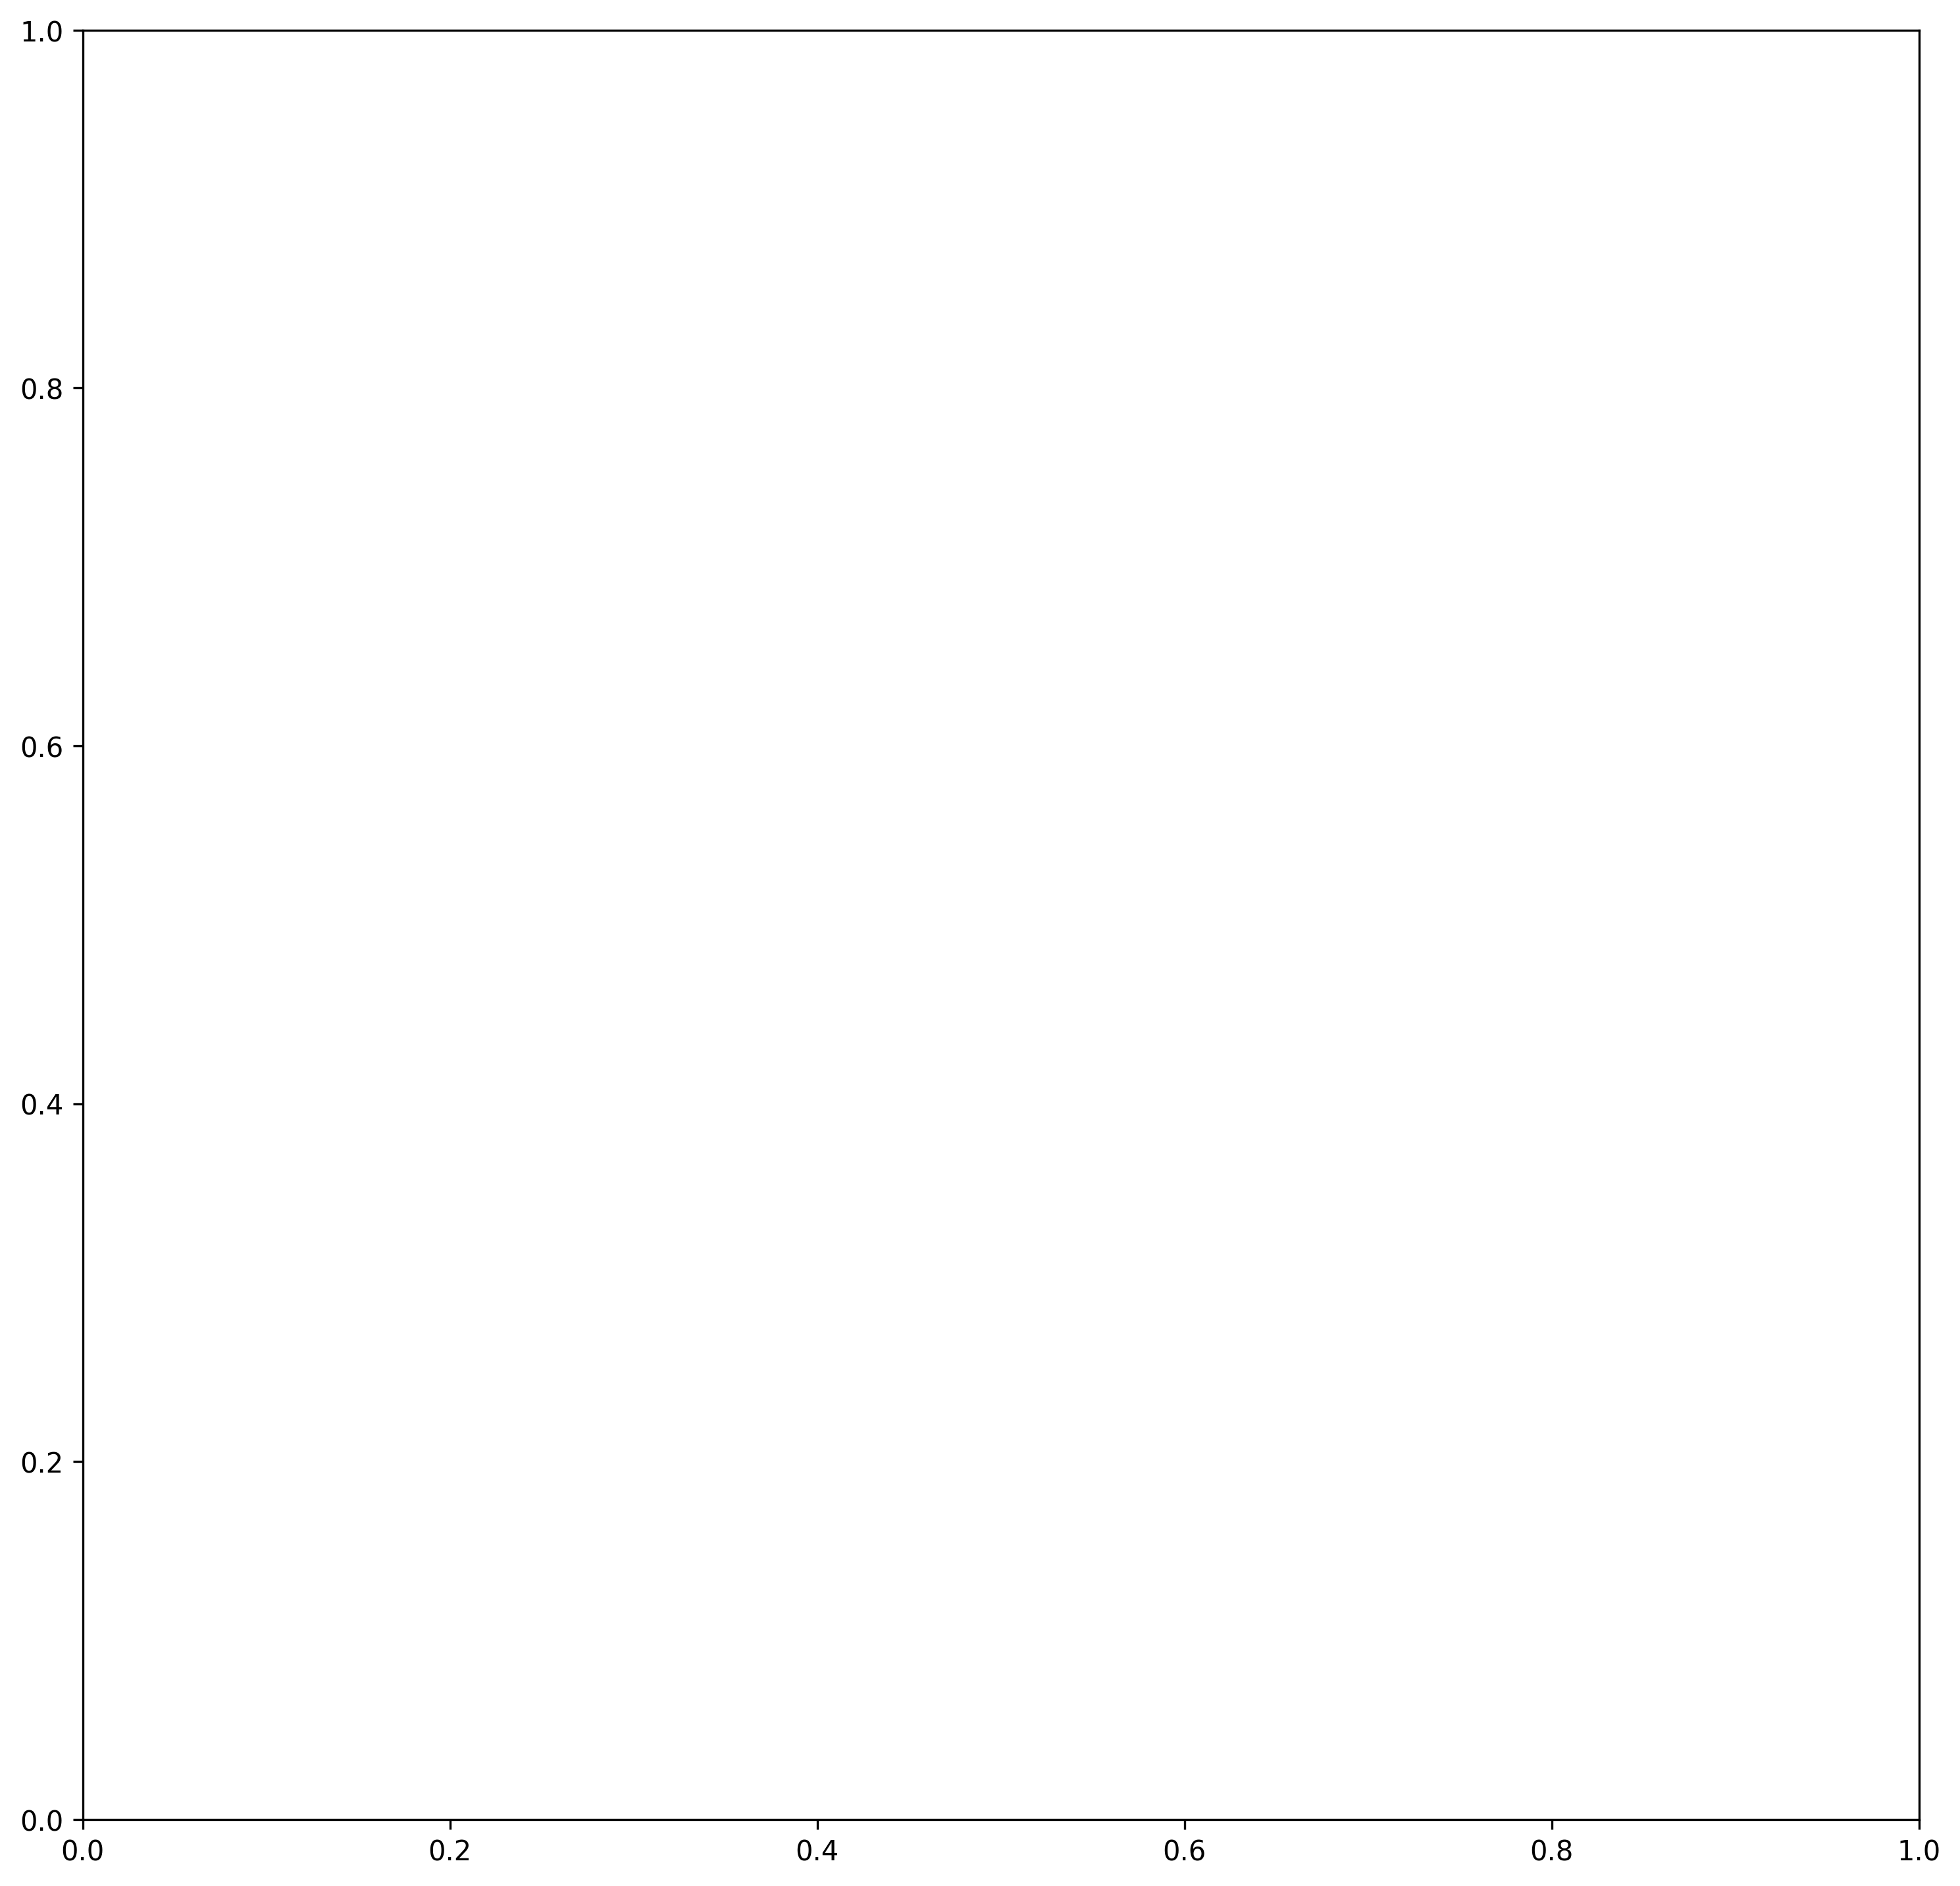

In [17]:
import importlib
importlib.reload(analysis_utils)

remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

tmp3 = tmp1.copy(deep=True)#.set_index('model')
#tmp3['fractional_gain_mean'] = tmp3['net_stabilization_mean'] / tmp3.at['ddG_dir', 'net_stabilization_mean']
#tmp3['fractional_gain_std'] = tmp3['net_stabilization_std'] / tmp3.at['ddG_dir', 'net_stabilization_mean']
#tmp3 = tmp3.reset_index()
#tmp3['fractional_gain_mean']

remap_cols = {'auprc': 'AUPRC', 'spearman': 'Spearman\'s ρ', 'auppc': 'mean PPC', 'aumsc': 'mean MSC', 'weighted_ndcg': 'wNDCG', 
    'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC', 'tp': 'True Positives', 'sensitivity': 'Sensitivity', 'mean_stabilization': 'Mean Stabilization',
    'net_stabilization': 'Net Stabilization', 'accuracy': 'Accuracy', 'mean_reciprocal_rank': 'MRR', 'n': 'n', 'MCC': 'MCC', 'recall@k1.0': 'Recall @ k'}

new_remap_cols = {}
for key, value in remap_cols.items():
    new_remap_cols[key + '_mean'] = value + ' mean'
    new_remap_cols[key + '_std'] = value + ' stdev'

s2 = tmp3.sort_values('spearman_mean', ascending=False).dropna(how='all', axis=1).reset_index()
s4 = s2.loc[s2['model'].isin(original_pred_cols_reduced + ['random_dir', 'ddG_dir'])]
#s4 = s3[['model', 'n_mean', 'MCC_mean', 'MCC_std', 'auprc_mean', 'auprc_std', 'spearman_mean', 'spearman_std', 'weighted_ndcg_mean', 'weighted_ndcg_std', 'recall@k1.0_mean', 'recall@k1.0_std', 'mean_stabilization_mean', 'mean_stabilization_std']]
s4['model'] = s4['model'].map(lambda x: remap_names_2.get(x, x[:-4]))
s5 = s4

tmp2 = s5[['model', 'weighted_ndcg_mean', 'weighted_ndcg_std',
                      'weighted_spearman_mean', 'weighted_spearman_std',
                      'spearman_mean', 'spearman_std',
                      'auprc_mean', 'auprc_std', 
                      'MCC_mean', 'MCC_std',  
                      #'recall@k0.0_mean', 'recall@k0.0_std', 
                      'recall@k1.0_mean', 'recall@k1.0_std', 
                      'mean_stabilization_mean', 'mean_stabilization_std']].set_index('model')

tmp2.columns = [new_remap_cols[c] for c in tmp2.columns]
tmp2 = tmp2.reset_index()

analysis_utils.make_bar_chart(tmp2, models=['ProteinMPNN 0.2', 'ESM-2 650M', 'Stability Oracle', 'Rosetta CartDDG', 'KORPM', 'DDGun3D', 'MAESTRO', 'Gaussian Noise'], title='S461', xlim=(-0.75, 1))

In [ ]:
tmp2

model  wNDCG mean   wNDCG stdev    ρ mean       ρ stdev  \
0          ΔΔG label    1.000000  1.501177e-16  1.000000  7.144709e-17   
1        DDG_checked    0.961266  3.126357e-02  0.965733  5.198038e-02   
2   Stability_Oracle    0.673598  5.558996e-02  0.646953  7.306998e-02   
3    Rosetta_CartDDG    0.615063  4.156165e-02  0.596556  9.521046e-02   
4            MAESTRO    0.587424  4.460880e-02  0.591701  7.101853e-02   
5             PremPS    0.599398  3.921215e-02  0.581820  9.244835e-02   
6           PopMusic    0.541100  4.099917e-02  0.581568  7.832136e-02   
7             INPS3D    0.618041  4.588622e-02  0.578729  8.085648e-02   
8            DDGun3D    0.601526  4.117602e-02  0.552062  1.080477e-01   
9               DUET    0.608876  5.142846e-02  0.543417  9.252389e-02   
10             DDGun    0.636471  4.226238e-02  0.540699  1.152172e-01   
11             KORPM    0.685732  4.729217e-02  0.540126  9.337099e-02   
12            KORPMD    0.685732  4.729217e-02  0.540126  9.337099e-02   
13           ACDC-NN    0.638238  4.276157e-02  0.524692  1.219021e-01   
14          INPS-Seq    0.618917  4.216383e-02  0.518704  1.042118e-01   
15       ACDC-NN-Seq    0.587947  3.624498e-02  0.499470  1.198637e-01   
16               SDM    0.616931  4.140596e-02  0.495305  9.522982e-02   
17              mCSM    0.547289  4.530960e-02  0.489065  9.521908e-02   
18               MIF    0.613786  4.138307e-02  0.467183  1.160888e-01   
19         ThermoNet    0.555921  3.898417e-02  0.463954  1.124021e-01   
20       I-Mutant3.0    0.604200  4.249779e-02  0.455808  1.059064e-01   
21        SAAFEC-Seq    0.604200  4.249779e-02  0.455808  1.059064e-01   
22    ProteinMPNN_30    0.594326  4.793235e-02  0.438511  1.261315e-01   
23              EvoD    0.531240  4.454664e-02  0.436706  1.138728e-01   
24    ProteinMPNN_20    0.604199  4.555516e-02  0.434900  1.244520e-01   
25        ESM-2_650M    0.657549  4.327871e-02  0.430435  1.063316e-01   
26              Ankh    0.618358  4.789012e-02  0.425307  9.871511e-02   
27         ESM-IF(M)    0.650746  4.199631e-02  0.419057  1.199500e-01   
28   I-Mutant3.0-Seq    0.584983  3.898173e-02  0.414539  1.194446e-01   
29       ESM-1V_mean    0.652501  4.261983e-02  0.409932  1.034369e-01   
30     ESM-1V_median    0.659243  4.387393e-02  0.403053  1.010152e-01   
31           Dynamut    0.492943  3.896048e-02  0.402930  1.103929e-01   
32            Dyna2D    0.492943  3.896048e-02  0.402930  1.103929e-01   
33            MIF-ST    0.685129  4.810830e-02  0.402069  1.252864e-01   
34            ESM-IF    0.639744  4.408149e-02  0.400014  1.174275e-01   
35    ProteinMPNN_10    0.595363  4.570406e-02  0.392560  1.314429e-01   
36        ESM-2_150M    0.632421  3.939579e-02  0.376814  1.095493e-01   
37       MutComputeX    0.533663  4.210089e-02  0.360891  1.182931e-01   
38             FoldX    0.546134  4.323858e-02  0.358991  1.481695e-01   
39          ESM-2_3B    0.616737  3.723973e-02  0.347527  1.033573e-01   
40             MuPro    0.530358  2.865445e-02  0.334748  1.202186e-01   
41         ESM-2_15B    0.638243  4.378910e-02  0.301220  1.129046e-01   
42       Tranception    0.627903  4.313620e-02  0.263678  1.316281e-01   
43        MSA-T_mean    0.563319  4.168550e-02  0.212062  9.616961e-02   
44      MSA-T_median    0.559461  4.074553e-02  0.205693  9.517979e-02   
45    Gaussian noise    0.477438  3.892254e-02  0.009466  4.776859e-02   

    AUPRC mean   AUPRC stdev  MCC mean  MCC stdev  recall@k mean  \
0     1.000000  1.247520e-16  1.000000   0.000000       1.000000   
1     0.855609  1.347210e-01  0.904464   0.094867       0.850234   
2     0.423306  6.454160e-02  0.356246   0.064520       0.135925   
3     0.477341  6.547894e-02  0.304245   0.063668       0.232845   
4     0.353824  5.077514e-02  0.314522   0.043994       0.000000   
5     0.335774  4.122405e-02  0.177764   0.075539       0.215413   
6     0.363042  4.117975e-02  0.261220   0.042483       0.09

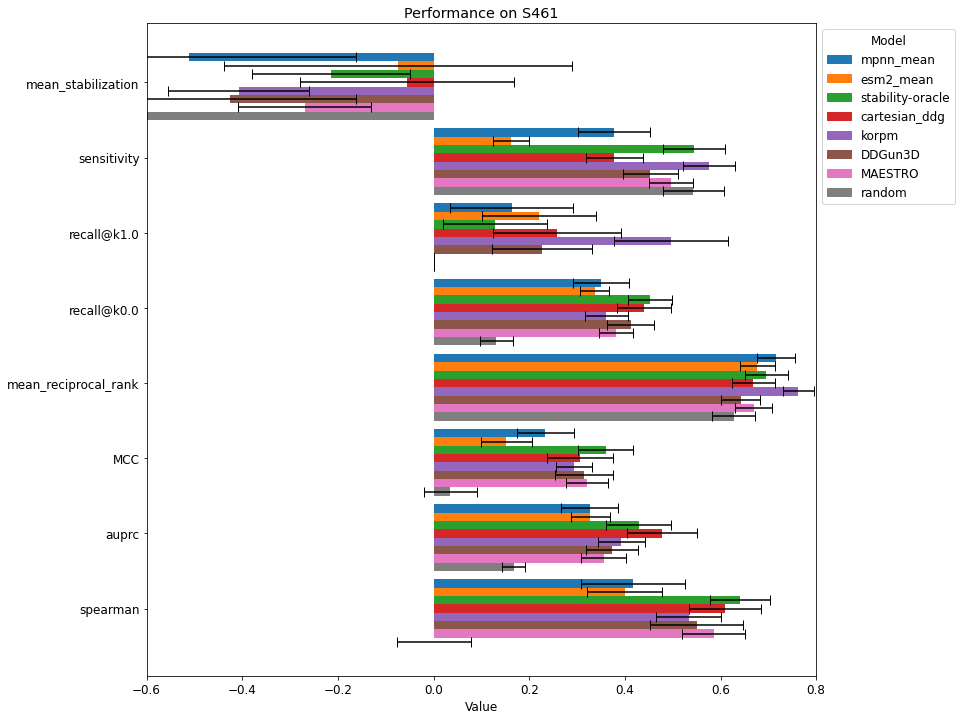

In [ ]:
importlib.reload(analysis_utils)
analysis_utils.make_bar_chart(tmp2.loc[tmp2['model'].isin(['MAESTRO_dir', 'random_dir', 'stability-oracle_dir', 'cartesian_ddg_dir', 'mpnn_mean_dir', 'esm2_mean_dir', 'korpm_dir', 'DDGun3D_dir'])], 
    models=['mpnn_mean', 'esm2_mean', 'stability-oracle', 'cartesian_ddg', 'korpm', 'DDGun3D', 'MAESTRO', 'random'], title='S461', figsize=(12,12), xlim=(-0.6, 0.8))

In [ ]:
#import importlib
#importlib.reload(analysis_utils)
#df = class_result.reset_index().set_index('model')[['MCC', 'auprc', 'spearman', 'mean_stabilization', 'sensitivity']]
#df = df.loc[['mif_mean_dir', 'esm2_mean_dir', 'cartesian_ddg_dir', 'KORPMD_dir', 'PremPS_dir', 'random_dir']]#, 'ProteinMPNN + Rosetta_CartDDG']]#, 'Clustered_Ensemble']]
#analysis_utils.make_radar_chart(df)

In [ ]:
# our Rosetta predictions are not that stronly correlated to Hernandez et. al, although ours tend to perform better
print(db_preds[['CartddgD_dir', 'cartesian_ddg_dir']].corr().iloc[1,0])

0.7745444496523972


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

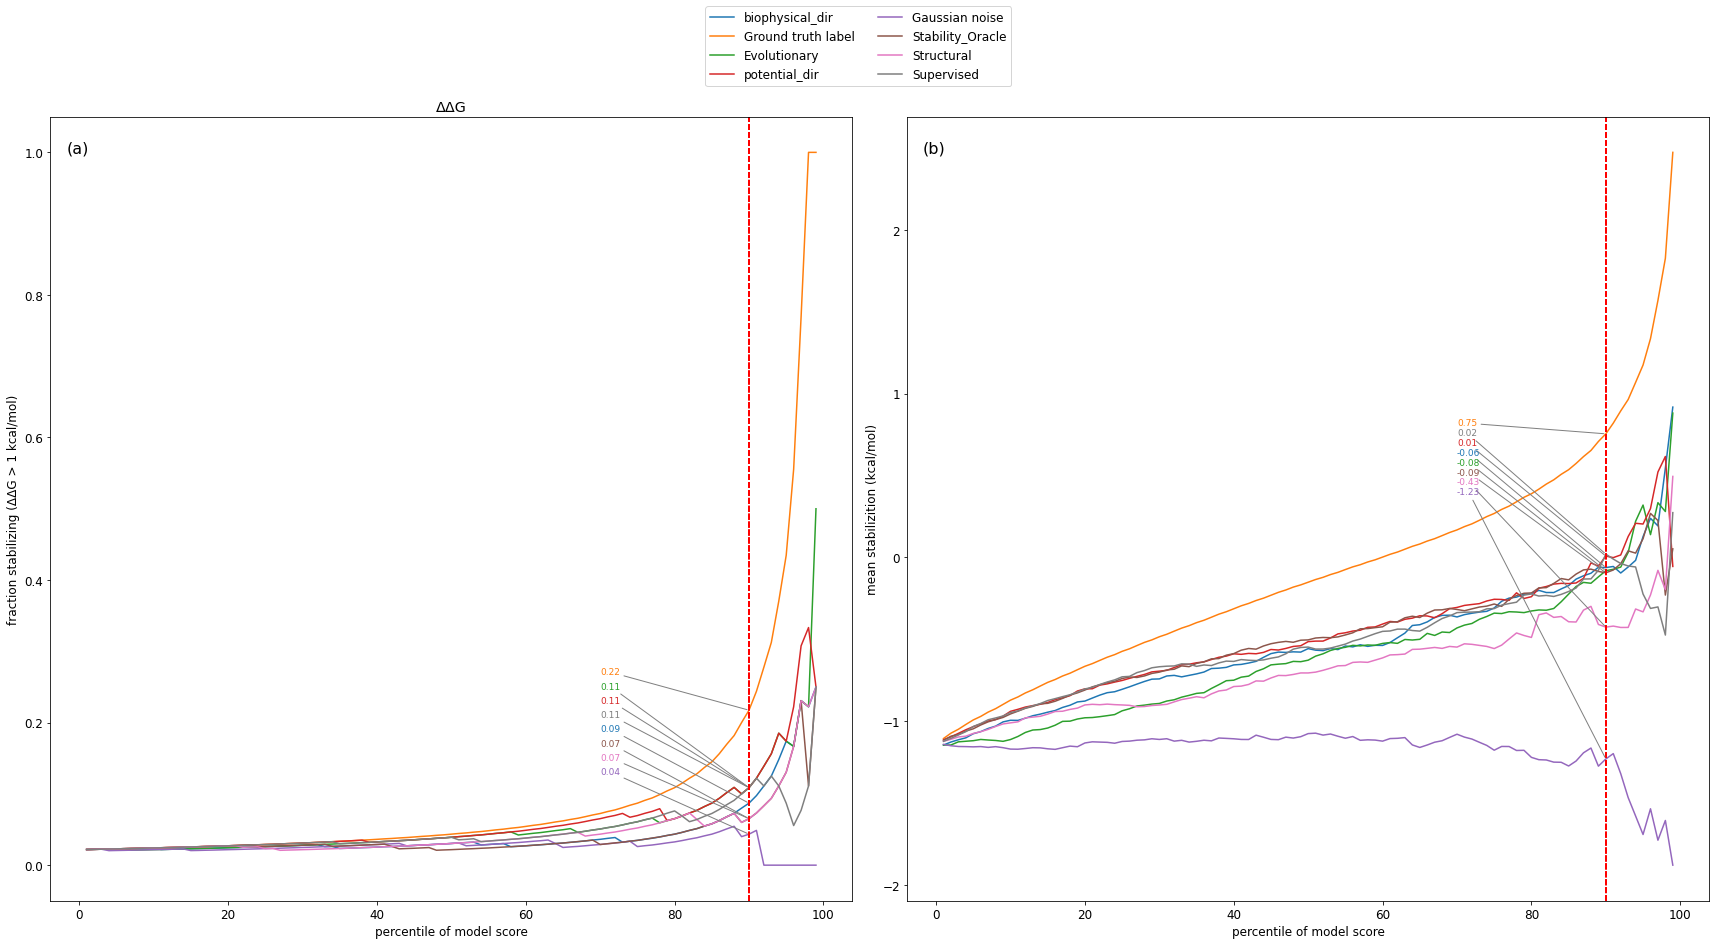

In [ ]:
# extra figure (not in text)
importlib.reload(analysis_utils)
class_result_new = analysis_utils.compute_stats(db_class, stats=('aumsc', 'auppc'), measurements=['ddG'], grouper=None, n_bootstraps=0)
analysis_utils.recovery_curves(class_result_new, ['structural_dir', 'evolutionary_dir', 'supervised_dir', 'biophysical_dir', 'potential_dir', 'stability-oracle_dir', 'ddG_dir', 'random_dir'], measurements=['ddG'])

In [ ]:
zs_feats = ['delta_kdh', 'delta_vol', 'rel_ASA']

db_ens = db_class.copy(deep=True).reset_index().set_index('uid2').reset_index(drop=True).set_index('uid') #.join(db_feats_2.drop(['SOL_ACC_dir', 'SOL_ACC_inv'], axis=1))
#db_ens = db_ens.rename({'ddG_dir': 'ddG'}, axis=1) 
#models = original_pred_cols_reduced + [c + '_dir' for c in zs_feats]
models = list(db_class.columns) + [z+'_dir' for z in zs_feats]
models.remove('ddG_dir')
#models.remove('ddG_dir')

for zs in zs_feats:
    db_ens[zs+'_dir'] = db_ens[zs]

print(len(db_ens))
db_ens['random_dir'] = np.random.normal(size=len(db_ens)) - 0.5
#db_ens['random_inv'] = np.random.normal(size=len(db_ens)) - 0.5
#db_ens = db_ens.drop(['KORPMD_dir', 'CartddgD_dir', 'FoldXD_dir', 'EvoD_dir', 'Dyna2D_dir', 'PopMsD_dir', 'DDGunD_dir', 'TNetD_dir', 'ACDCNND_dir'], axis=1)
dfm = db_ens.copy(deep=True)
models

461


['KORPMD_dir',
 'EvoD_dir',
 'Dyna2D_dir',
 'ACDC-NN-Seq_dir',
 'ACDC-NN_dir',
 'DDG_checked_dir',
 'DDGun3D_dir',
 'DDGun_dir',
 'DUET_dir',
 'Dynamut_dir',
 'FoldX_dir',
 'I-Mutant3.0-Seq_dir',
 'I-Mutant3.0_dir',
 'INPS-Seq_dir',
 'INPS3D_dir',
 'MAESTRO_dir',
 'MuPro_dir',
 'PopMusic_dir',
 'PremPS_dir',
 'SAAFEC-Seq_dir',
 'SDM_dir',
 'ThermoNet_dir',
 'esmif_monomer_dir',
 'mCSM_dir',
 'mpnn_10_00_dir',
 'mpnn_20_00_dir',
 'mpnn_30_00_dir',
 'esmif_multimer_dir',
 'esm2_dir',
 'esm2_15B_half_dir',
 'msa_transformer_median_dir',
 'msa_transformer_mean_dir',
 'tranception_dir',
 'esm2_150M_dir',
 'esm2_650M_dir',
 'esm1v_median_dir',
 'esm1v_mean_dir',
 'ankh_dir',
 'mif_dir',
 'mifst_dir',
 'korpm_dir',
 'mutcomputex_dir',
 'stability-oracle_dir',
 'cartesian_ddg_dir',
 'cluster',
 'structural_dir',
 'evolutionary_dir',
 'supervised_dir',
 'potential_dir',
 'biophysical_dir',
 'mpnn_rosetta_dir',
 'mpnn_oracle_dir',
 'mpnn_mean_dir',
 'esmif_mean_dir',
 'mif_mean_dir',
 'esm2_mean

In [ ]:
weights = [1, 0.5, 0.2]
#weights2 = [0.8, 0.3]

all_cols = []

tmp = []
for model1 in models:
    for model2 in models:
        if model1[-4:] == model2[-4:] and model1 != model2: #(model1.split('_')[0] != model2.split('_')[0]) and (model1[:4] != model2[:4]) and
            for weight in weights:
                tmp.append(pd.Series(dfm[model1]/dfm[model1].std() + dfm[model2]/dfm[model2].std() * weight, name=f'{model1} + {model2} * {weight}'))
                all_cols.append(f'{model1} + {model2} * {weight}')
                #for model3 in models:
                #    if model2 != model3 and model1 != model3:
                #        for weight2 in weights2:
                #            tmp.append(pd.Series(dfm[model1] + dfm[model2] * weight + dfm[model3] * weight2, name=f'{model1} + {model2} * {weight} + {model3} * {weight2}'))
                #            all_cols.append(f'{model1} + {model2} * {weight} + {model3} * {weight2}')

dfm = pd.concat([dfm] + tmp, axis=1)
dfm = dfm.join(db_runtimes)
#dfm.to_csv(os.path.join(path, 'results', 'ensemble_s461_2_models_3_weights_preds.csv'))
dfm.columns

Index(['KORPMD_dir', 'EvoD_dir', 'Dyna2D_dir', 'ACDC-NN-Seq_dir',
       'ACDC-NN_dir', 'DDG_checked_dir', 'DDGun3D_dir', 'DDGun_dir',
       'DUET_dir', 'Dynamut_dir',
       ...
       'runtime_esm1v_3_dir', 'runtime_esm1v_4_dir', 'runtime_esm1v_5_dir',
       'runtime_esm1v_median_dir', 'runtime_esm1v_mean_dir',
       'runtime_ankh_dir', 'runtime_mif_dir', 'runtime_mifst_dir',
       'runtime_cartesian_ddg_dir', 'runtime_korpm'],
      dtype='object', length=10361)

In [ ]:
dfm['runtime_msa_transformer_mean_dir']

uid        uid2     
1A0F_11A   1A0F_11A     12.488210
1BA3_461D  1BA3_457D    23.508211
1BA3_489D  1BA3_485D    23.392597
1BA3_489K  1BA3_485K    23.388429
1BA3_489M  1BA3_485M    23.384603
                          ...    
4HE7_19G   4HE7_19G      0.008642
4HE7_19K   4HE7_19K      0.008364
5JXB_329G  5JXB_25G     31.028471
5JXB_329P  5JXB_25P     30.867426
5OAQ_429H  5OAQ_199H     3.280921
Name: runtime_msa_transformer_mean_dir, Length: 461, dtype: float64

In [ ]:
def get_summary_df(db_complete, cols=None, saveloc=os.path.join(path, 'results', 'ensemble_s461_2_models_3_weights_results.csv'), stats=(), stacked=False):

    assert os.path.exists(os.path.dirname(saveloc))
    assert not os.path.exists(saveloc)
    #if cols is None:
    #    cols = db_complete.columns.drop(['code'])#, 'ddG_dir', 'ddG_inv'])

    #if not stacked:
    #    db_stacked = stack_frames(db_complete)
    #else:
    #    db_stacked = db_complete
    #db_stacked['code'] = list(db_stacked.reset_index()['uid'].str[:4])

    df_summ = analysis_utils.compute_stats(db_complete, stats=(), grouper='cluster', measurements=['ddG']).reset_index().set_index(['measurement', 'model'])#.join(df_reg) #.drop('n_total', axis=1))
    df_summ = df_summ.reset_index().rename({'index': 'model'}, axis=1).set_index(['measurement', 'model_type', 'model', 'class'])
    df_summ = df_summ.sort_index(level=1).sort_index(level=0)#.drop_duplicates()
    df_summ.to_csv(saveloc)
    return df_summ

In [ ]:
import importlib
importlib.reload(analysis_utils)
# takes a long time to compute and has already been done
#d1 = get_summary_df(dfm, saveloc=os.path.join(path, 'data', 'ensemble_s461_2_models_3_weights_revisions_runtimes.csv'), stats=()) 

d1 = pd.read_csv(os.path.join(path, 'data', 'ensemble_s461_2_models_3_weights_revisions_runtimes.csv')).set_index(['measurement', 'model_type', 'model', 'class'])

['ACDC-NN_dir', 'DDGun3D_dir', 'DUET_dir', 'Dynamut_dir', 'FoldX_dir', 'EvoD_dir', 'I-Mutant3.0_dir', 'INPS3D_dir', 'MAESTRO_dir', 'MUpro_dir', 'PopMusic_dir', 'PremPS_dir', 'ThermoNet_dir', 'SAAFEC-Seq_dir', 'SDM_dir', 'mCSM_dir', 'cartesian_ddg_dir', 'esm1v_mean_dir', 'ankh_dir', 'msa_transformer_mean_dir', 'tranception_dir', 'esm2_dir', 'esmif_multimer_dir', 'KORPMD_dir', 'mpnn_20_00_dir', 'mif_dir', 'mifst_dir', 'stability-oracle_dir', 'mutcomputex_dir']
461
0.14890636102584937
['Stability Oracle', 'Rosetta CartDDG', 'PremPS_dir', 'PopMusic_dir', 'MAESTRO_dir', 'INPS3D_dir', 'DDGun3D_dir', 'DUET_dir', 'ACDC-NN_dir', 'KORPMD_dir', 'mCSM_dir', 'SDM_dir', 'ThermoNet_dir', 'SAAFEC-Seq_dir', 'I-Mutant3.0_dir', 'EvoD_dir', 'MIF', 'Ankh', 'ProteinMPNN 0.2', 'Dynamut_dir', 'ESM-1V mean', 'ESM-IF', 'MIF-ST', 'ESM-2 3B', 'MutComputeX', 'FoldX_dir', 'Tranception', 'MSA-T mean']


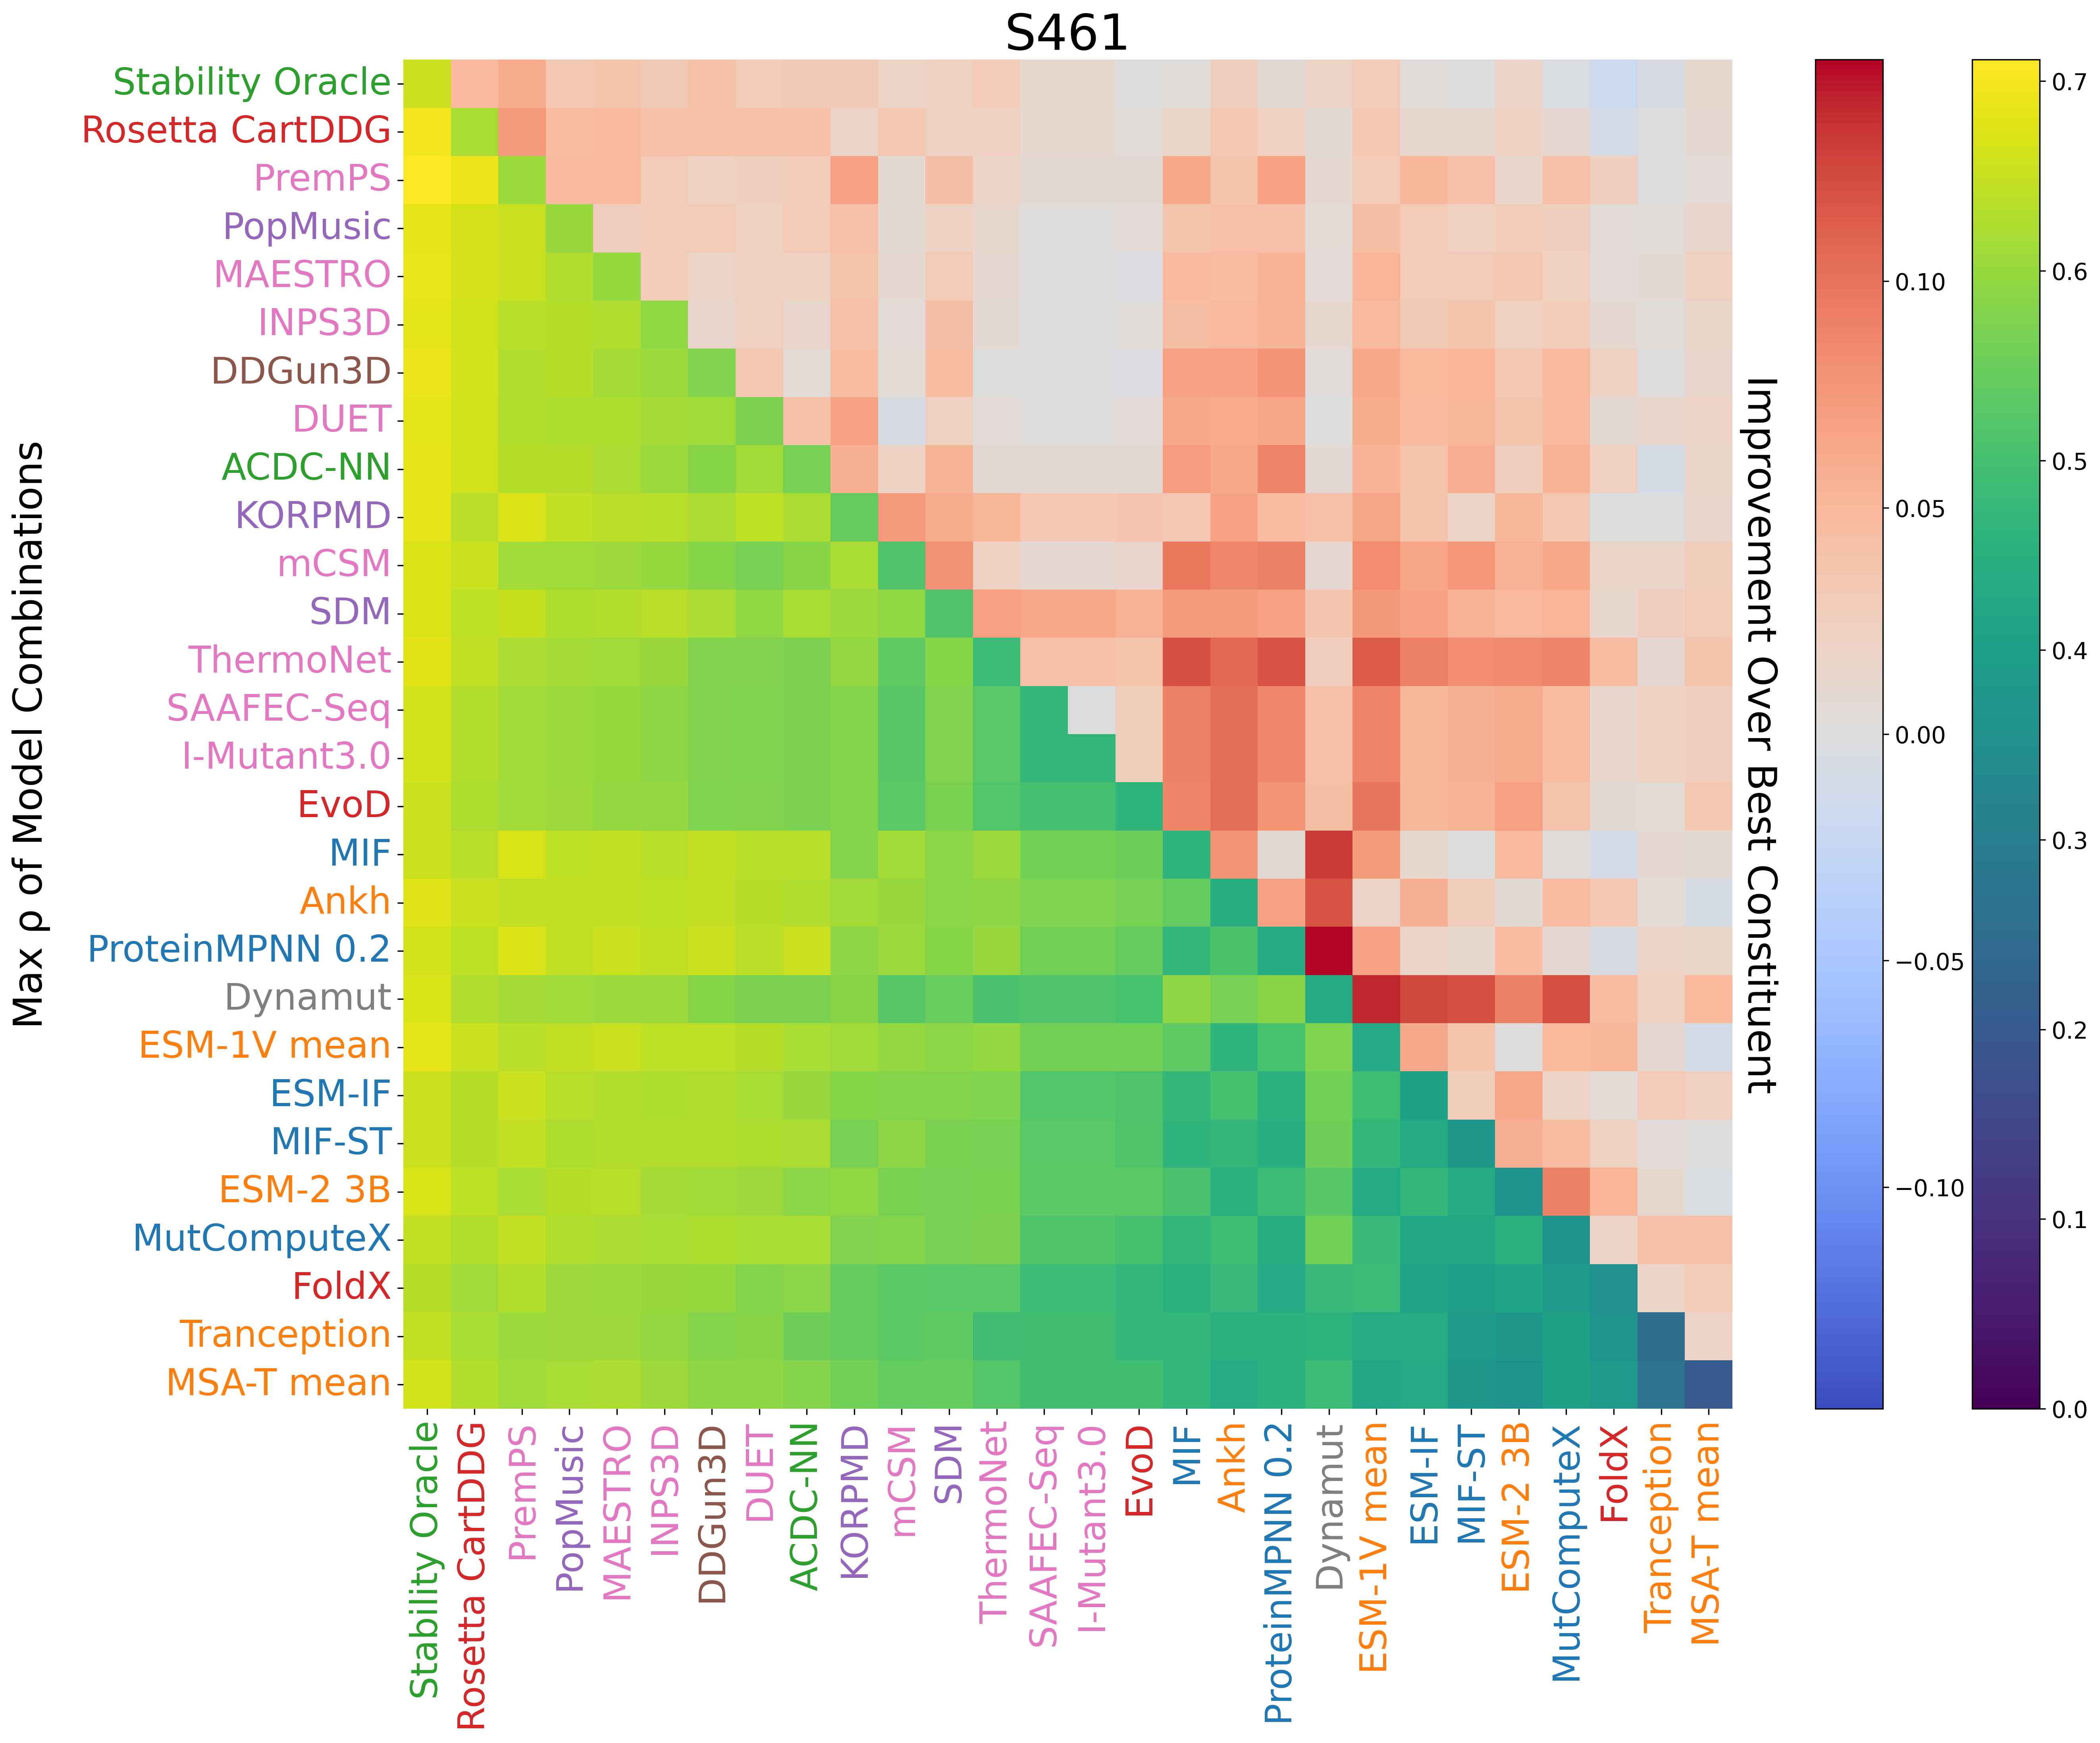

{'SDM', 'DUET', 'ThermoNet', 'Stability Oracle', 'PopMusic', 'Ankh', 'PremPS', 'Dynamut', 'ACDC-NN', 'mCSM', 'INPS3D', 'ESM-2 3B', 'Rosetta CartDDG', 'ProteinMPNN 0.2', 'I-Mutant3.0', 'MIF', 'MAESTRO', 'KORPMD', 'ESM-1V mean', 'MSA-T mean', 'DDGun3D', 'ESM-IF'}


model1  weight1           model2  weight2  spearman      corr  \
rank                                                                            
1     Stability Oracle      1.0           PremPS      0.5  0.711284  0.550506   
2     Stability Oracle      1.0  Rosetta CartDDG      0.5  0.697886  0.635180   
3               PremPS      1.0  Rosetta CartDDG      1.0  0.693728  0.530449   
4     Stability Oracle      1.0          DDGun3D      0.5  0.691471  0.602141   
5     Stability Oracle      1.0          MAESTRO      0.5  0.688428  0.638792   
...                ...      ...              ...      ...       ...       ...   
374           ESM-2 3B      1.0       MSA-T mean      0.2  0.359221  0.627177   
375              FoldX      1.0            FoldX      0.0  0.351706  1.000000   
376        Tranception      1.0       MSA-T mean      0.5  0.271344  0.351386   
377        Tranception      1.0      Tranception      0.0  0.252171  1.000000   
378         MSA-T mean      1.0       MSA-T mean      0.0  0.198427  1.000000   

      runtime_cpu   runtime_gpu  
rank                             
1         -0.0001     -0.000100  
2     368117.9999     -0.000100  
3     368117.9999     -0.000100  
4         -0.0001     -0.000100  
5         -0.0001     -0.000100  
...           ...           ...  
374       -0.0001   4218.066468  
375       -0.0001     -0.000100  
376       -0.0001  10151.365200  
377       -0.0001   6012.661391  
378       -0.0001   4138.703709  

[378 rows x 8 columns]

In [ ]:
import importlib
importlib.reload(analysis_utils)

custom_colors = {#'ACDC-NN-Seq_dir': 'blue', 
                 'ACDC-NN_dir': 'purple',
                 #'DDGun_dir': 'blue',
                 'DDGun3D_dir': 'purple',
                 'DUET_dir': 'purple',
                 'Dynamut_dir': 'orange',
                 'FoldX_dir': 'red',
                 'EvoD_dir': 'green',
                 'I-Mutant3.0_dir': 'orange',
                 #'I-Mutant3.0-Seq_dir': 'green',
                 #'INPS-Seq_dir': 'blue',
                 'INPS3D_dir': 'purple',
                 'MAESTRO_dir': 'purple',
                 'MUpro_dir': 'red',
                 'PopMusic_dir': 'red',
                 'PremPS_dir': 'purple',
                 'ThermoNet_dir': 'purple',
                 'SAAFEC-Seq_dir': 'orange',
                 'SDM_dir': 'purple',
                 #'SOL_ACC_dir': 'red',
                 #'delta_kdh': 'blue',
                 #'delta_vol': 'blue',
                 #'abs_ASA': 'red',
                 'ThermoNet_dir': 'red',
                 'mCSM_dir': 'red',
                 'cartesian_ddg_dir': 'red',
                 'esm1v_mean_dir': 'blue',
                 #'esm2_mean_dir': 'blue',
                 'ankh_dir': 'blue',
                 'msa_transformer_mean_dir': 'blue',
                 'tranception_dir': 'blue',
                 'esm2_dir': 'blue',
                 #'esmif_monomer': 'red',
                 'esmif_multimer_dir': 'red',
                 'KORPMD_dir': 'red',
                 'mpnn_20_00_dir': 'red',
                 'mif_dir': 'red',
                 'mifst_dir': 'purple',
                 #'mpnn_mean_dir': 'red',
                 #'esmif_mean_dir': 'red',
                 #'mif_mean_dir': 'red',
                 'stability-oracle_dir': 'orange',
                 'mutcomputex_dir': 'orange'
                 }

subset = list(custom_colors.keys())
print(subset)

#custom_colors = dict(zip([key+'_dir' for key in custom_colors.keys()], list(custom_colors.values())))
#print(custom_colors)

measurement = 'ddG'
statistic = 'spearman'

db_ddg_ = db_ddg.copy(deep=True)
db_ddg_ = db_ddg_.rename({'ddG_dir': 'ddG'}, axis=1).reset_index('uid2', drop=True)
d3 = d1.copy(deep=True)

#dfm['code'] = dfm.index.str[:4]

stat_df_, delta_df = analysis_utils.model_combinations_heatmap(d3, dfm.fillna(0), db_ddg_, statistic, measurement, threshold=0, subset=subset, n_bootstraps=0, grouper=None, upper='delta', annot=False, title='S461')
#stat_df = analysis_utils.model_combinations_heatmap_2(d2, dfm, statistic, direction, upper, threshold=None, custom_colors=custom_colors)
stat_df = stat_df_
stat_df = stat_df.drop_duplicates(subset=[f'{statistic}', 'runtime_cpu', 'runtime_gpu']).reset_index(drop=True).sort_values(f'{statistic}', ascending=False).reset_index(drop=True).reset_index()
stat_df['model1'] = stat_df['model1'].map(lambda x: remap_names_2.get(x, x[:-4]))
stat_df['model2'] = stat_df['model2'].map(lambda x: remap_names_2.get(x, x[:-4]))

stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models_ = set(list(out['model1']) + list(out['model2']))
print(models_)
stat_df

In [ ]:
stat_df_ = stat_df.applymap(lambda x: np.nan if x==-0.0001 else x)
stat_df_ = stat_df.applymap(lambda x: round(x, 2) if type(x)==float else x)
for source, target in remap_names.items():
    stat_df_.loc[stat_df_['model1']==source, 'model1'] = target
    stat_df_.loc[stat_df_['model2']==source, 'model2'] = target
stat_df_ = stat_df_.reset_index().drop('weight1', axis=1).rename({'rank': 'Rank', 'model1': 'Base model', 'model2': 'Added Model', 'weight2': 'Weight', 'corr': 'Model Correlation', 'runtime_cpu': 'CPU time (s)', 'runtime_gpu': 'GPU time (s)', 'spearman': 'Spearman\'s rho'}, axis=1)
stat_df_.to_csv('../data/stat_df_s461.csv')
stat_df_

Rank        Base model      Added Model  Weight  Spearman's rho  \
0       1  Stability Oracle           PremPS     0.5            0.71   
1       2  Stability Oracle  Rosetta CartDDG     0.5            0.70   
2       3            PremPS  Rosetta CartDDG     1.0            0.69   
3       4  Stability Oracle          DDGun3D     0.5            0.69   
4       5  Stability Oracle          MAESTRO     0.5            0.69   
..    ...               ...              ...     ...             ...   
373   374          ESM-2 3B       MSA-T mean     0.2            0.36   
374   375             FoldX            FoldX     0.0            0.35   
375   376       Tranception       MSA-T mean     0.5            0.27   
376   377       Tranception      Tranception     0.0            0.25   
377   378        MSA-T mean       MSA-T mean     0.0            0.20   

     Model Correlation  CPU time (s)  GPU time (s)  
0                 0.55          -0.0         -0.00  
1                 0.64      368118.0         -0.00  
2                 0.53      368118.0         -0.00  
3                 0.60          -0.0         -0.00  
4                 0.64          -0.0         -0.00  
..                 ...           ...           ...  
373               0.63          -0.0       4218.07  
374               1.00          -0.0         -0.00  
375               0.35          -0.0      10151.37  
376               1.00          -0.0       6012.66  
377               1.00          -0.0       4138.70  

[378 rows x 8 columns]

['ACDC-NN_dir', 'DDGun3D_dir', 'DUET_dir', 'Dynamut_dir', 'FoldX_dir', 'EvoD_dir', 'I-Mutant3.0_dir', 'INPS3D_dir', 'MAESTRO_dir', 'MUpro_dir', 'PopMusic_dir', 'PremPS_dir', 'ThermoNet_dir', 'SAAFEC-Seq_dir', 'SDM_dir', 'mCSM_dir', 'cartesian_ddg_dir', 'esm1v_mean_dir', 'ankh_dir', 'msa_transformer_mean_dir', 'tranception_dir', 'esm2_dir', 'esmif_multimer_dir', 'KORPMD_dir', 'mpnn_20_00_dir', 'mif_dir', 'mifst_dir', 'stability-oracle_dir', 'mutcomputex_dir']
461
42.424
['Tranception', 'Rosetta CartDDG', 'MSA-T mean', 'ESM-1V mean', 'PremPS_dir', 'MIF-ST', 'Ankh', 'SAAFEC-Seq_dir', 'I-Mutant3.0_dir', 'INPS3D_dir', 'ESM-2 3B', 'PopMusic_dir', 'ESM-IF', 'mCSM_dir', 'Stability Oracle', 'DUET_dir', 'MIF', 'MAESTRO_dir', 'ProteinMPNN 0.2', 'ACDC-NN_dir', 'DDGun3D_dir', 'MutComputeX', 'KORPMD_dir', 'EvoD_dir', 'SDM_dir', 'Dynamut_dir', 'ThermoNet_dir', 'FoldX_dir']


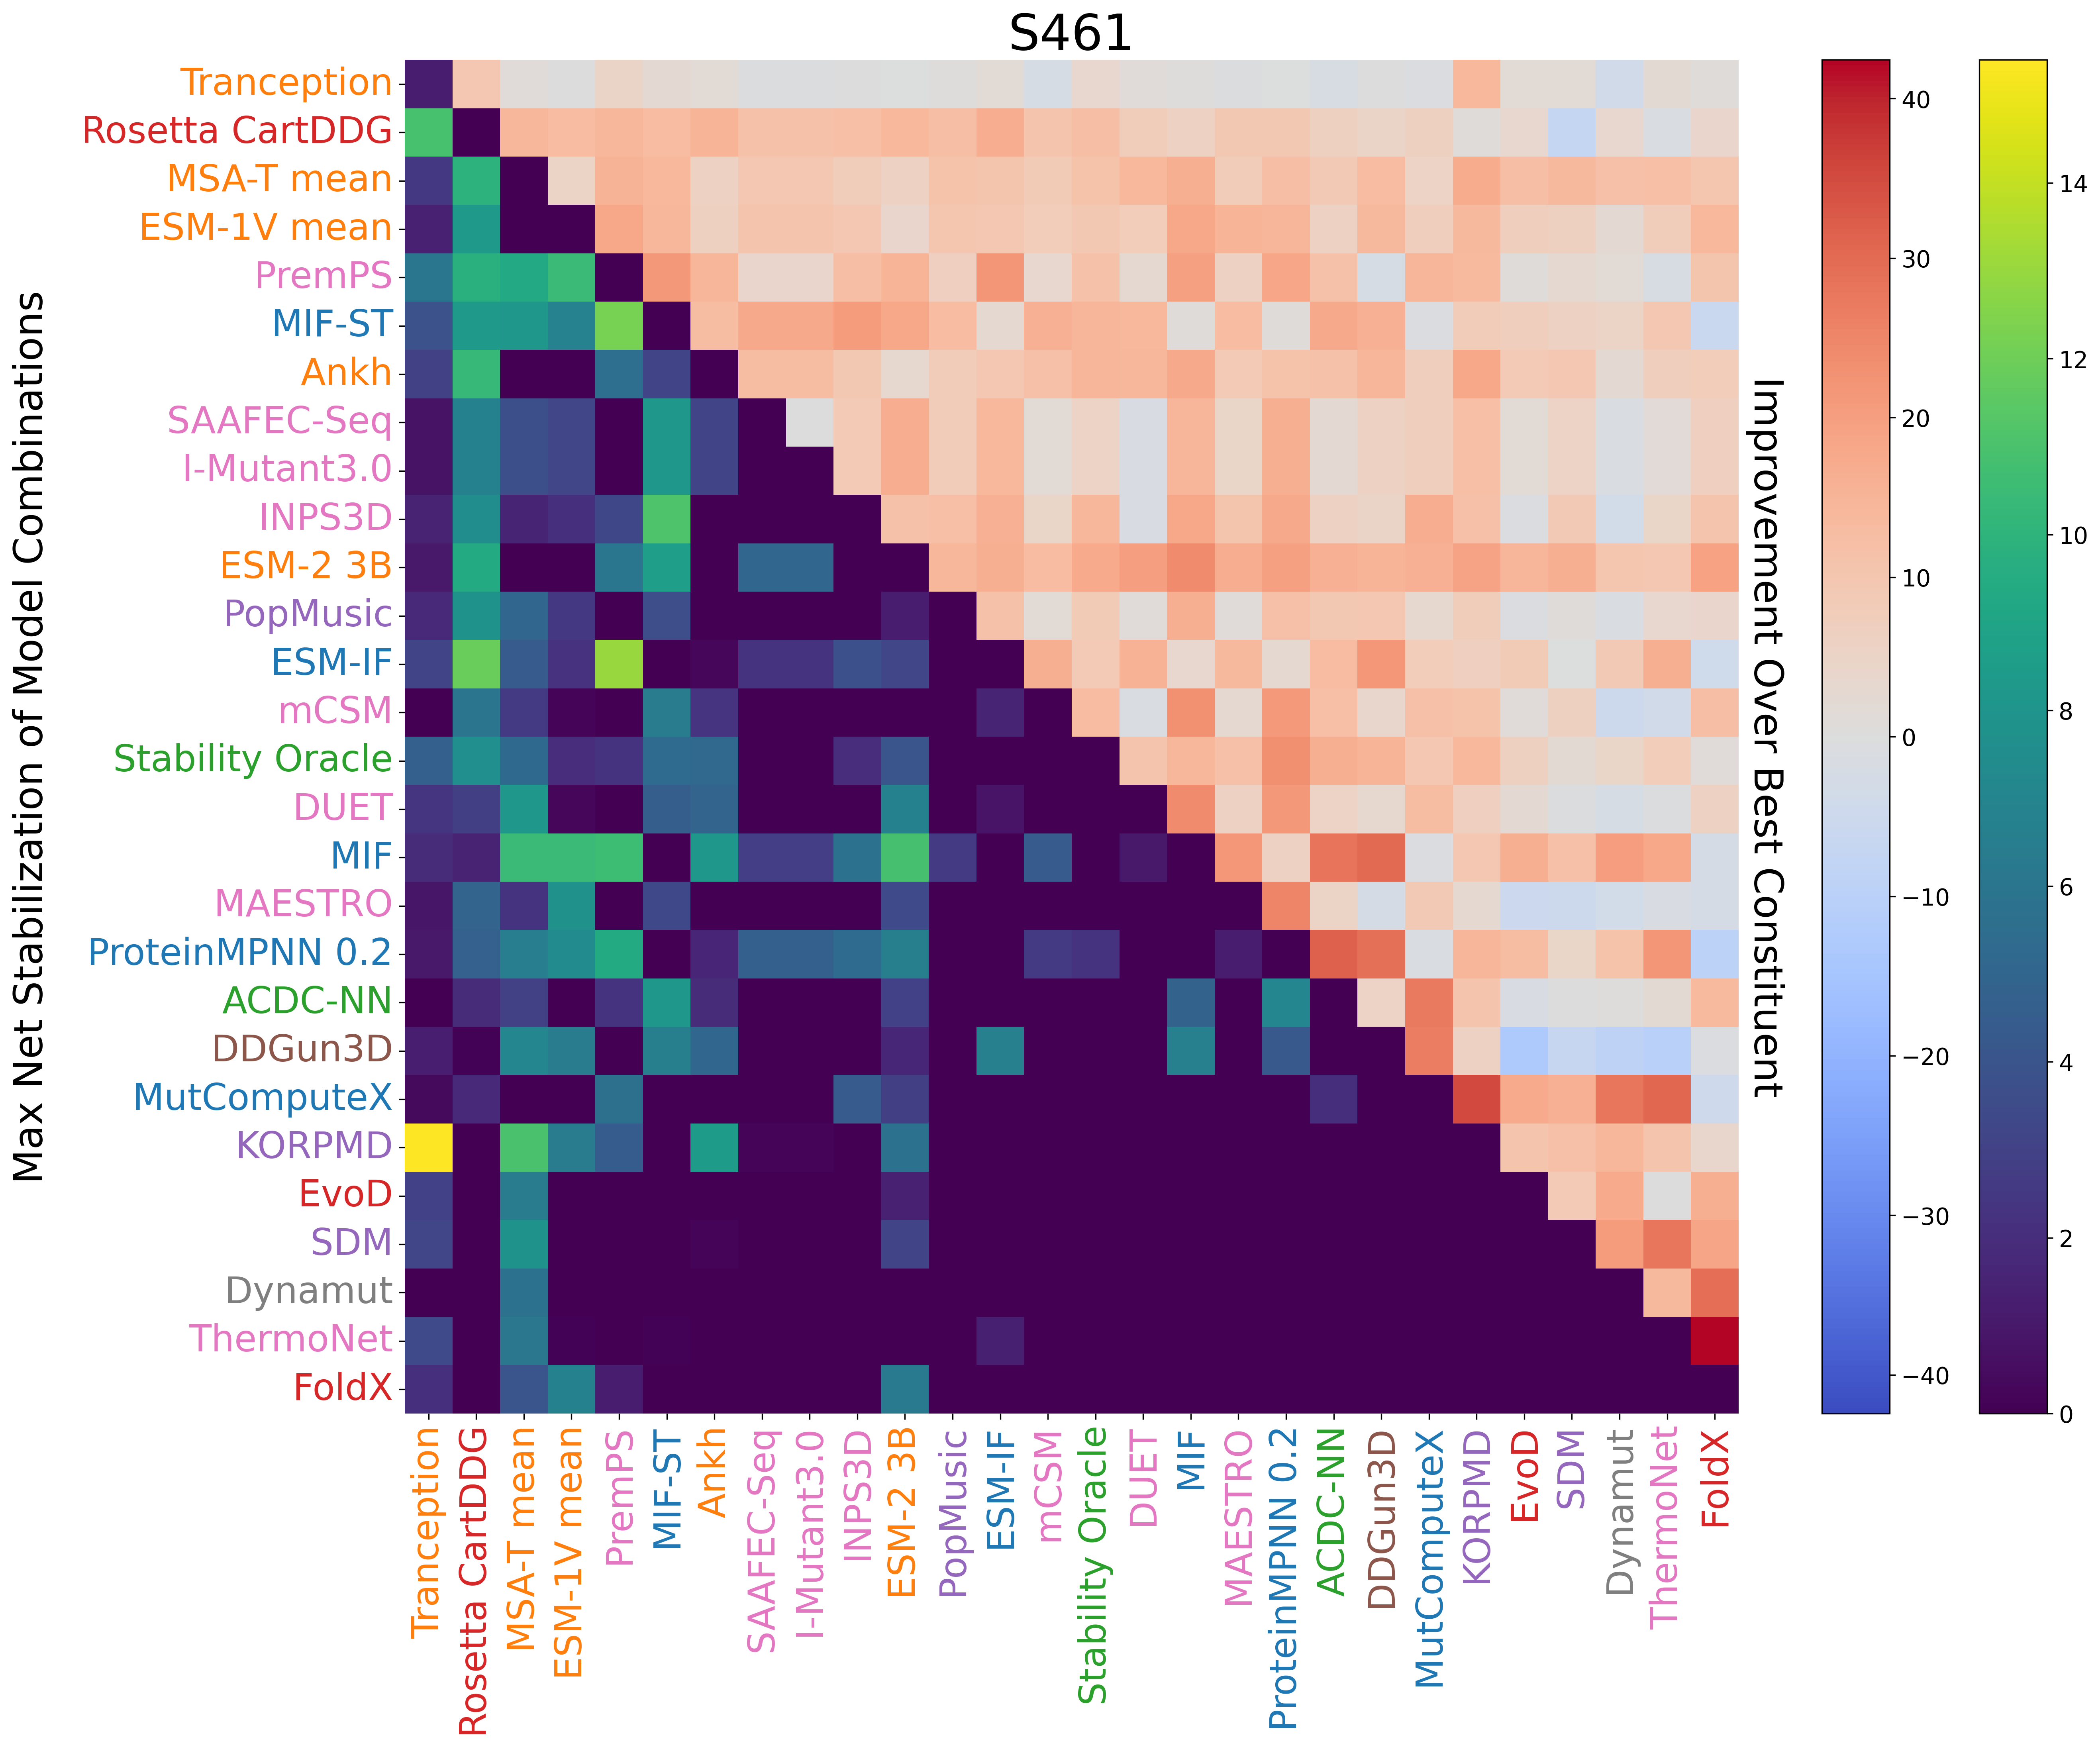

{'SDM', 'DUET', 'PopMusic', 'Ankh', 'PremPS', 'Tranception', 'ACDC-NN', 'INPS3D', 'ESM-2 3B', 'Rosetta CartDDG', 'ProteinMPNN 0.2', 'MIF-ST', 'I-Mutant3.0', 'MIF', 'KORPMD', 'MAESTRO', 'ESM-1V mean', 'MSA-T mean', 'ESM-IF'}


model1  weight1           model2  weight2  net_stabilization  \
rank                                                                      
1     Tranception      1.0           KORPMD      0.5             15.400   
2          PremPS      1.0           ESM-IF      1.0             13.046   
3          PremPS      1.0           MIF-ST      1.0             12.242   
4          ESM-IF      1.0  Rosetta CartDDG      0.5             11.904   
5          MIF-ST      1.0           INPS3D      0.5             11.080   
...           ...      ...              ...      ...                ...   
374       Dynamut      1.0        ThermoNet      0.5            -67.973   
375           SDM      1.0              SDM      0.0            -78.823   
376       Dynamut      1.0          Dynamut      0.0            -81.885   
377     ThermoNet      1.0        ThermoNet      0.0            -88.527   
378         FoldX      1.0            FoldX      0.0           -105.924   

          corr  runtime_cpu  runtime_gpu  
rank                                      
1     0.293999       0.6914  6012.661391  
2     0.288006      -0.0001    78.337373  
3     0.264921      -0.0001    16.700319  
4     0.459011  368117.9999    78.337373  
5     0.315261      -0.0001    16.700319  
...        ...          ...          ...  
374   0.614034      -0.0001    -0.000100  
375   1.000000      -0.0001    -0.000100  
376   1.000000      -0.0001    -0.000100  
377   1.000000      -0.0001    -0.000100  
378   1.000000      -0.0001    -0.000100  

[378 rows x 8 columns]

In [ ]:
custom_colors = {#'ACDC-NN-Seq_dir': 'blue', 
                 'ACDC-NN_dir': 'purple',
                 #'DDGun_dir': 'blue',
                 'DDGun3D_dir': 'purple',
                 'DUET_dir': 'purple',
                 'Dynamut_dir': 'orange',
                 'FoldX_dir': 'red',
                 'EvoD_dir': 'green',
                 'I-Mutant3.0_dir': 'orange',
                 #'I-Mutant3.0-Seq_dir': 'green',
                 #'INPS-Seq_dir': 'blue',
                 'INPS3D_dir': 'purple',
                 'MAESTRO_dir': 'purple',
                 'MUpro_dir': 'red',
                 'PopMusic_dir': 'red',
                 'PremPS_dir': 'purple',
                 'ThermoNet_dir': 'purple',
                 'SAAFEC-Seq_dir': 'orange',
                 'SDM_dir': 'purple',
                 #'SOL_ACC_dir': 'red',
                 #'delta_kdh': 'blue',
                 #'delta_vol': 'blue',
                 #'abs_ASA': 'red',
                 'ThermoNet_dir': 'red',
                 'mCSM_dir': 'red',
                 'cartesian_ddg_dir': 'red',
                 'esm1v_mean_dir': 'blue',
                 #'esm2_mean_dir': 'blue',
                 'ankh_dir': 'blue',
                 'msa_transformer_mean_dir': 'blue',
                 'tranception_dir': 'blue',
                 'esm2_dir': 'blue',
                 #'esmif_monomer': 'red',
                 'esmif_multimer_dir': 'red',
                 'KORPMD_dir': 'red',
                 'mpnn_20_00_dir': 'red',
                 'mif_dir': 'red',
                 'mifst_dir': 'purple',
                 #'mpnn_mean_dir': 'red',
                 #'esmif_mean_dir': 'red',
                 #'mif_mean_dir': 'red',
                 'stability-oracle_dir': 'orange',
                 'mutcomputex_dir': 'orange'
                 }

subset = list(custom_colors.keys())
print(subset)

#custom_colors = dict(zip([key+'_dir' for key in custom_colors.keys()], list(custom_colors.values())))
#print(custom_colors)

measurement = 'ddG'
statistic = 'net_stabilization'

db_ddg_ = db_ddg.copy(deep=True)
db_ddg_ = db_ddg_.rename({'ddG_dir': 'ddG'}, axis=1).reset_index('uid2', drop=True)
d3 = d1.copy(deep=True)

#dfm['code'] = dfm.index.str[:4]

stat_df_, delta_df = analysis_utils.model_combinations_heatmap(d3, dfm.fillna(0), db_ddg_, statistic, measurement, threshold=0, subset=subset, n_bootstraps=0, grouper=None, upper='delta', annot=False, title='S461')
#stat_df = analysis_utils.model_combinations_heatmap_2(d2, dfm, statistic, direction, upper, threshold=None, custom_colors=custom_colors)
stat_df = stat_df_
stat_df = stat_df.drop_duplicates(subset=[f'{statistic}', 'runtime_cpu', 'runtime_gpu']).reset_index(drop=True).sort_values(f'{statistic}', ascending=False).reset_index(drop=True).reset_index()
stat_df['model1'] = stat_df['model1'].map(lambda x: remap_names_2.get(x, x[:-4]))
stat_df['model2'] = stat_df['model2'].map(lambda x: remap_names_2.get(x, x[:-4]))

stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models_ = set(list(out['model1']) + list(out['model2']))
print(models_)
stat_df

In [ ]:
stat_df_ = stat_df.applymap(lambda x: np.nan if x==-0.0001 else x)
stat_df_ = stat_df.applymap(lambda x: round(x, 2) if type(x)==float else x)
for source, target in remap_names.items():
    stat_df_.loc[stat_df_['model1']==source, 'model1'] = target
    stat_df_.loc[stat_df_['model2']==source, 'model2'] = target
stat_df_ = stat_df_.reset_index().drop('weight1', axis=1).rename({'rank': 'Rank', 'model1': 'Base model', 'model2': 'Added Model', 'weight2': 'Weight', 'corr': 'Model Correlation', 'runtime_cpu': 'CPU time (s)', 'runtime_gpu': 'GPU time (s)', 'spearman': 'Spearman\'s rho'}, axis=1)
stat_df_.to_csv('../data/stat_df_net_stab_s461.csv')
stat_df_

Rank   Base model      Added Model  Weight  net_stabilization  \
0       1  Tranception           KORPMD     0.5              15.40   
1       2       PremPS           ESM-IF     1.0              13.05   
2       3       PremPS           MIF-ST     1.0              12.24   
3       4       ESM-IF  Rosetta CartDDG     0.5              11.90   
4       5       MIF-ST           INPS3D     0.5              11.08   
..    ...          ...              ...     ...                ...   
373   374      Dynamut        ThermoNet     0.5             -67.97   
374   375          SDM              SDM     0.0             -78.82   
375   376      Dynamut          Dynamut     0.0             -81.89   
376   377    ThermoNet        ThermoNet     0.0             -88.53   
377   378        FoldX            FoldX     0.0            -105.92   

     Model Correlation  CPU time (s)  GPU time (s)  
0                 0.29          0.69       6012.66  
1                 0.29         -0.00         78.34  
2                 0.26         -0.00         16.70  
3                 0.46     368118.00         78.34  
4                 0.32         -0.00         16.70  
..                 ...           ...           ...  
373               0.61         -0.00         -0.00  
374               1.00         -0.00         -0.00  
375               1.00         -0.00         -0.00  
376               1.00         -0.00         -0.00  
377               1.00         -0.00         -0.00  

[378 rows x 8 columns]

In [ ]:
stat_df.sort_values('spearman', ascending=False).head(30)

model1  weight1           model2  weight2  spearman      corr  \
rank                                                                            
1     Stability Oracle      1.0           PremPS      0.5  0.711284  0.550506   
2     Stability Oracle      1.0  Rosetta CartDDG      0.5  0.697886  0.635180   
3               PremPS      1.0  Rosetta CartDDG      1.0  0.693728  0.530449   
4     Stability Oracle      1.0          DDGun3D      0.5  0.691471  0.602141   
5     Stability Oracle      1.0          MAESTRO      0.5  0.688428  0.638792   
6     Stability Oracle      1.0         PopMusic      0.5  0.683770  0.677917   
7     Stability Oracle      1.0          ACDC-NN      0.5  0.683536  0.610308   
8     Stability Oracle      1.0           KORPMD      0.5  0.683518  0.576436   
9     Stability Oracle      1.0           INPS3D      0.5  0.683225  0.635682   
10    Stability Oracle      1.0             DUET      0.5  0.681801  0.606646   
11    Stability Oracle      1.0      ESM-1V mean      0.5  0.681101  0.393205   
12    Stability Oracle      1.0        ThermoNet      0.5  0.680380  0.495816   
13    Stability Oracle      1.0             Ankh      0.2  0.676569  0.398259   
14              PremPS      1.0  ProteinMPNN 0.2      0.5  0.672140  0.260751   
15    Stability Oracle      1.0              SDM      0.5  0.671739  0.534215   
16              PremPS      1.0           KORPMD      0.5  0.670947  0.435620   
17    Stability Oracle      1.0             mCSM      0.5  0.670861  0.549127   
18    Stability Oracle      1.0          Dynamut      0.5  0.669302  0.432218   
19    Stability Oracle      1.0         ESM-2 3B      0.2  0.668324  0.336141   
20              PremPS      1.0              MIF      0.5  0.667488  0.302040   
21             MAESTRO      1.0  Rosetta CartDDG      1.0  0.666620  0.615163   
22            PopMusic      1.0  Rosetta CartDDG      1.0  0.664885  0.658597   
23    Stability Oracle      1.0      I-Mutant3.0      0.2  0.662759  0.564920   
24    Stability Oracle      1.0       MSA-T mean      0.2  0.662426  0.149493   
25     Rosetta CartDDG      1.0          DDGun3D      0.5  0.662034  0.643771   
26     Rosetta CartDDG      1.0             DUET      0.5  0.660640  0.580324   
27     Rosetta CartDDG      1.0          ACDC-NN      0.5  0.660503  0.604894   
28     Rosetta CartDDG      1.0           INPS3D      0.5  0.660287  0.632687   
29    Stability Oracle      1.0  ProteinMPNN 0.2      0.2  0.660272  0.527303   
30    Stability Oracle      1.0           ESM-IF      0.2  0.655055  0.565552   

      runtime_cpu  runtime_gpu  
rank                            
1         -0.0001    -0.000100  
2     368117.9999    -0.000100  
3     368117.9999    -0.000100  
4         -0.0001    -0.000100  
5         -0.0001    -0.000100  
6         -0.0001    -0.000100  
7         -0.0001    -0.000100  
8         -0.0001    -0.000100  
9         -0.0001    -0.000100  
10        -0.0001    -0.000100  
11        -0.0001   156.649497  
12        -0.0001    -0.000100  
13        -0.0001   104.397596  
14        -0.0001     4.562497  
15        -0.0001    -0.000100  
16        -0.0001    -0.000100  
17        -0.0001    -0.000100  
18        -0.0001    -0.000100  
19        -0.0001    79.362659  
20        -0.0001    42.318466  
21    368117.9999    -0.000100  
22    368117.9999    -0.000100  
23        -0.0001    -0.000100  
24        -0.0001  4138.703709  
25    368117.9999    -0.000100  
26    368117.9999    -0.000100  
27    368117.9999    -0.000100  
28    368117.9999    -0.000100  
29        -0.0001     4.562497  
30        -0.0001    78.337373

460
{'model1': ['ACDC-NN_dir', 'ACDC-NN_dir', 'DDGun3D_dir', 'ACDC-NN_dir', 'DUET_dir', 'ACDC-NN_dir', 'ACDC-NN_dir', 'Dynamut_dir', 'ACDC-NN_dir', 'I-Mutant3.0_dir', 'ACDC-NN_dir', 'INPS3D_dir', 'ACDC-NN_dir', 'MAESTRO_dir', 'ACDC-NN_dir', 'PremPS_dir', 'ACDC-NN_dir', 'SAAFEC-Seq_dir', 'ACDC-NN_dir', 'ThermoNet_dir', 'ACDC-NN_dir', 'mCSM_dir', 'ACDC-NN_dir', 'stability-oracle_dir', 'ACDC-NN_dir', 'EvoD_dir', 'ACDC-NN_dir', 'FoldX_dir', 'cartesian_ddg_dir', 'ACDC-NN_dir', 'ACDC-NN_dir', 'ankh_dir', 'esm1v_mean_dir', 'ACDC-NN_dir', 'ACDC-NN_dir', 'esm2_dir', 'msa_transformer_mean_dir', 'ACDC-NN_dir', 'tranception_dir', 'ACDC-NN_dir', 'ACDC-NN_dir', 'KORPMD_dir', 'PopMusic_dir', 'ACDC-NN_dir', 'ACDC-NN_dir', 'SDM_dir', 'ACDC-NN_dir', 'esmif_multimer_dir', 'mif_dir', 'ACDC-NN_dir', 'ACDC-NN_dir', 'mifst_dir', 'ACDC-NN_dir', 'mpnn_20_00_dir', 'ACDC-NN_dir', 'mutcomputex_dir', 'DDGun3D_dir', 'DDGun3D_dir', 'DDGun3D_dir', 'DUET_dir', 'DDGun3D_dir', 'Dynamut_dir', 'I-Mutant3.0_dir', 'DDGun3D_

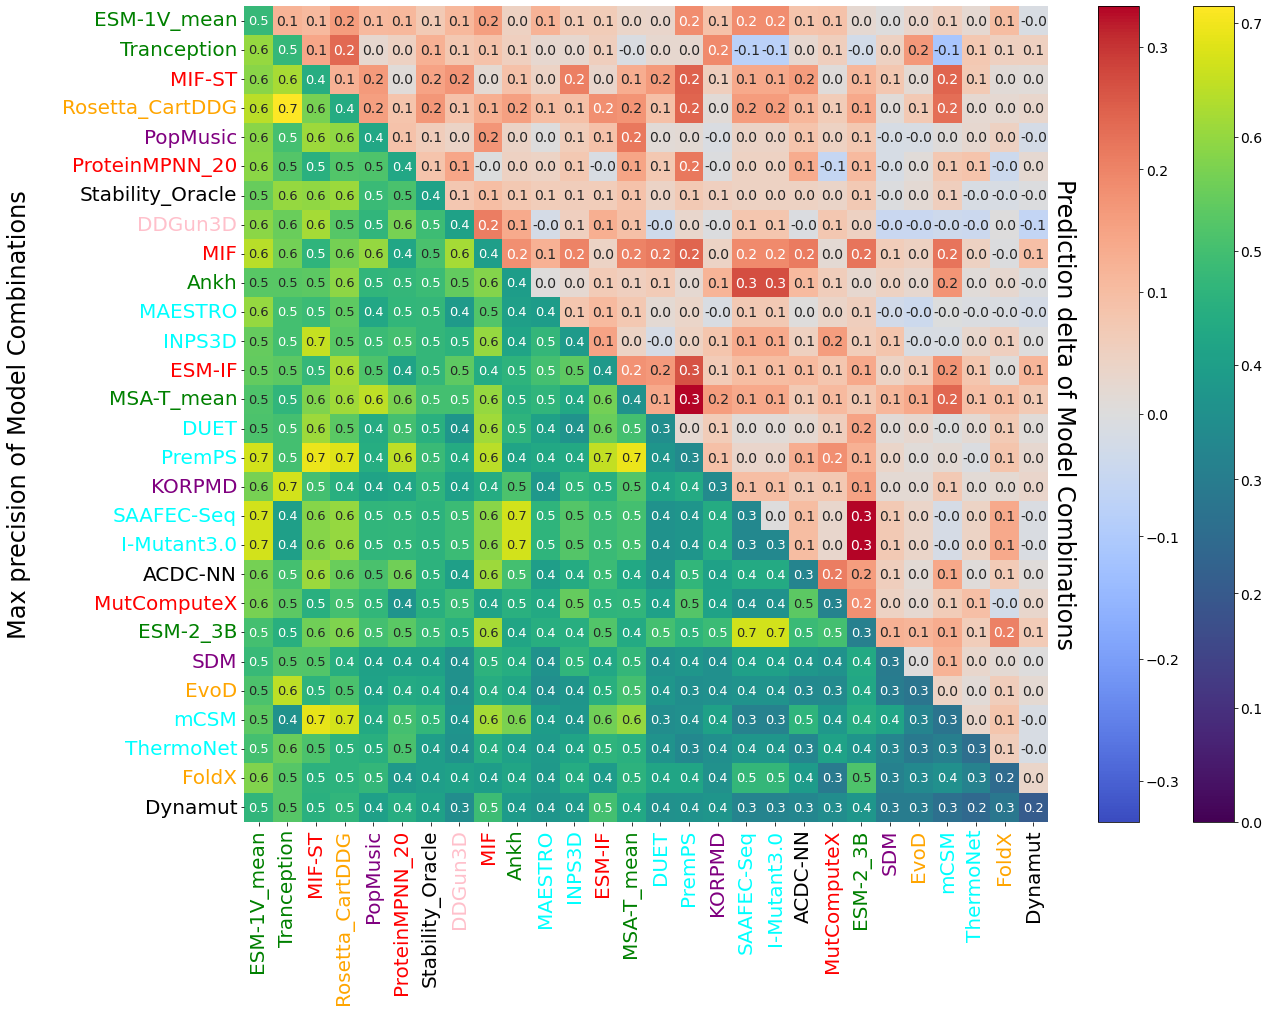

KeyError: Index(['mean_precision'], dtype='object')

In [ ]:
import importlib
importlib.reload(analysis_utils)

subset = list(custom_colors.keys())

#custom_colors = dict(zip([key+'_dir' for key in custom_colors.keys()], list(custom_colors.values())))
#print(custom_colors)

measurement = 'ddG'
statistic = 'precision'

db_ddg_ = db_ddg.copy(deep=True)
db_ddg_ = db_ddg_.rename({'ddG_dir': 'ddG'}, axis=1).reset_index('uid2', drop=True)
d3 = d1.copy(deep=True)

dfm['code'] = dfm.index.str[:4]

stat_df, delta_df = analysis_utils.model_combinations_heatmap(d3, dfm, db_ddg_, statistic, measurement, subset=subset, n_bootstraps=0, threshold=0, sigdigs=1, grouper=None, upper='delta')
#stat_df = analysis_utils.model_combinations_heatmap_2(d2, dfm, statistic, direction, upper, threshold=None, custom_colors=custom_colors)
stat_df = stat_df.drop_duplicates(subset=f'mean_{statistic}').reset_index(drop=True).sort_values(f'mean_{statistic}', ascending=False).reset_index(drop=True).reset_index()

stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models_ = set(list(out['model1']) + list(out['model2']))
print(models_)
#out.to_csv('../../zeroshot suppl/supp_table_ndcg.csv')
out

461
inf


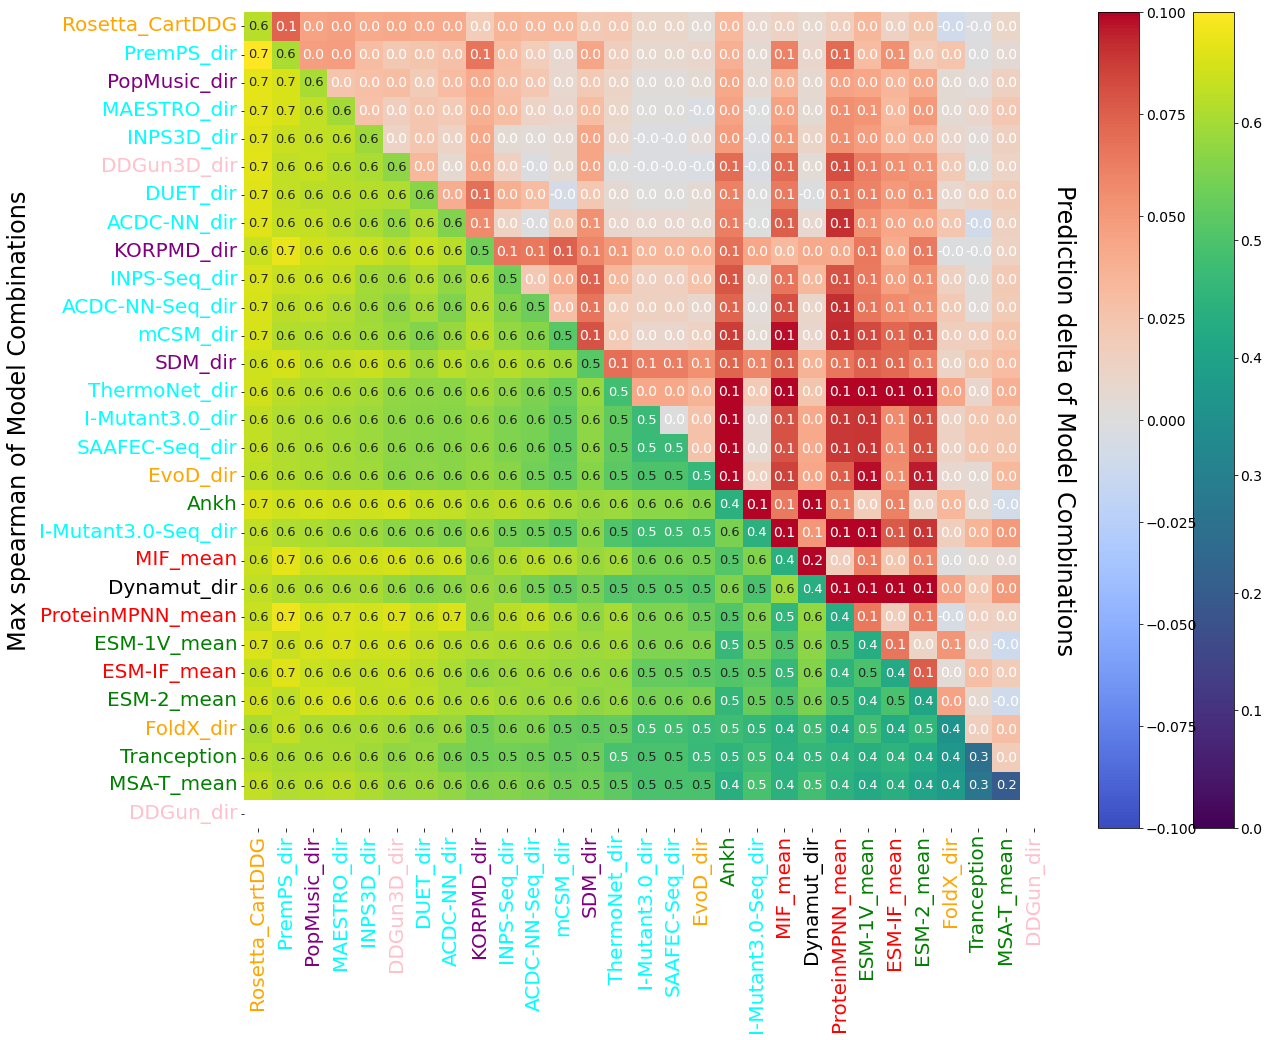

{'PremPS_dir', 'PopMusic_dir', 'mif_mean_dir', 'esmif_mean_dir', 'INPS3D_dir', 'esm1v_mean_dir', 'ACDC-NN_dir', 'mpnn_mean_dir', 'DUET_dir', 'KORPMD_dir', 'INPS-Seq_dir', 'MAESTRO_dir', 'DDGun3D_dir', 'cartesian_ddg_dir'}


model1 weight1             model2 weight2 mean_spearman  \
rank                                                                       
1            PremPS_dir       1  cartesian_ddg_dir       1      0.693728   
2     cartesian_ddg_dir       1         PremPS_dir     0.5      0.687144   
3            PremPS_dir       1  cartesian_ddg_dir     0.5        0.6812   
4            PremPS_dir       1      mpnn_mean_dir     0.5      0.675442   
5            PremPS_dir       1         KORPMD_dir     0.5      0.670947   
6           MAESTRO_dir       1  cartesian_ddg_dir       1       0.66662   
7            PremPS_dir       1       mif_mean_dir     0.5      0.666048   
8          PopMusic_dir       1  cartesian_ddg_dir       1      0.664885   
9     cartesian_ddg_dir       1        MAESTRO_dir     0.5      0.664821   
10           KORPMD_dir       1         PremPS_dir       1      0.664668   
11    cartesian_ddg_dir       1       PopMusic_dir     0.5      0.664207   
12    cartesian_ddg_dir       1        DDGun3D_dir     0.5      0.662034   
13    cartesian_ddg_dir       1        DDGun3D_dir       1      0.661152   
14    cartesian_ddg_dir       1         PremPS_dir     0.2      0.660724   
15    cartesian_ddg_dir       1           DUET_dir     0.5       0.66064   
16    cartesian_ddg_dir       1        ACDC-NN_dir     0.5      0.660503   
17          ACDC-NN_dir       1  cartesian_ddg_dir       1      0.660345   
18    cartesian_ddg_dir       1         INPS3D_dir     0.5      0.660287   
19    cartesian_ddg_dir       1         INPS3D_dir       1      0.659764   
20             DUET_dir       1  cartesian_ddg_dir       1      0.659048   
21           PremPS_dir       1     esmif_mean_dir     0.5      0.658911   
22          DDGun3D_dir       1      mpnn_mean_dir     0.5       0.65837   
23           PremPS_dir       1       mif_mean_dir       1      0.657392   
24           PremPS_dir       1      mpnn_mean_dir       1      0.655595   
25    cartesian_ddg_dir       1       INPS-Seq_dir     0.5      0.655379   
26          MAESTRO_dir       1  cartesian_ddg_dir     0.5      0.655005   
27          ACDC-NN_dir       1      mpnn_mean_dir     0.5      0.654544   
28          MAESTRO_dir       1      mpnn_mean_dir     0.5      0.654293   
29           PremPS_dir       1     esmif_mean_dir       1      0.653569   
30    cartesian_ddg_dir       1     esm1v_mean_dir     0.5      0.653354   

     p_value  
rank          
1        NaN  
2        NaN  
3        NaN  
4        NaN  
5        NaN  
6        NaN  
7        NaN  
8        NaN  
9        NaN  
10       NaN  
11       NaN  
12       NaN  
13       NaN  
14       NaN  
15       NaN  
16       NaN  
17       NaN  
18       NaN  
19       NaN  
20       NaN  
21       NaN  
22       NaN  
23       NaN  
24       NaN  
25       NaN  
26       NaN  
27       NaN  
28       NaN  
29       NaN  
30       NaN

In [ ]:
import importlib
importlib.reload(analysis_utils)

custom_colors = {'ACDC-NN-Seq_dir': 'blue', 
                 'ACDC-NN_dir': 'purple',
                 'DDGun_dir': 'blue',
                 'DDGun3D_dir': 'purple',
                 'DUET_dir': 'purple',
                 'Dynamut_dir': 'orange',
                 'FoldX_dir': 'red',
                 'EvoD_dir': 'green',
                 'I-Mutant3.0_dir': 'orange',
                 'I-Mutant3.0-Seq_dir': 'green',
                 'INPS-Seq_dir': 'blue',
                 'INPS3D_dir': 'purple',
                 'MAESTRO_dir': 'purple',
                 'MUpro_dir': 'red',
                 'PopMusic_dir': 'red',
                 'PremPS_dir': 'purple',
                 'ThermoNet_dir': 'purple',
                 'SAAFEC-Seq_dir': 'orange',
                 'SDM_dir': 'purple',
                 #'SOL_ACC_dir': 'red',
                 #'delta_kdh': 'blue',
                 #'delta_vol': 'blue',
                 #'abs_ASA': 'red',
                 'ThermoNet_dir': 'red',
                 'mCSM_dir': 'red',
                 'cartesian_ddg_dir': 'red',
                 'esm1v_mean_dir': 'blue',
                 'esm2_mean_dir': 'blue',
                 'ankh_dir': 'blue',
                 'msa_transformer_mean_dir': 'blue',
                 'tranception_dir': 'blue',
                 #'esmif_monomer': 'red',
                 #'esmif_multimer': 'red',
                 'KORPMD_dir': 'red',
                 #'mpnn_20_00_dir': 'red',
                 #'mif_dir': 'red',
                 #'mifst': 'purple',
                 'mpnn_mean_dir': 'red',
                 'esmif_mean_dir': 'red',
                 'mif_mean_dir': 'red',
                 'stability-oracle': 'red',
                 'mutcomputex': 'red'
                 }

subset = list(custom_colors.keys())

#custom_colors = dict(zip([key+'_dir' for key in custom_colors.keys()], list(custom_colors.values())))
#print(custom_colors)

measurement = 'ddG'
statistic = 'spearman'

db_ddg_ = db_ddg.copy(deep=True)
db_ddg_ = db_ddg_.rename({'ddG_dir': 'ddG'}, axis=1).reset_index('uid2', drop=True)
d3 = d1.copy(deep=True)

dfm['code'] = dfm.index.str[:4]

stat_df, delta_df = analysis_utils.model_combinations_heatmap(d3, dfm, db_ddg_, statistic, measurement, subset=subset, n_bootstraps=0, threshold=0, sigdigs=1, grouper=None, upper='delta')
#stat_df = analysis_utils.model_combinations_heatmap_2(d2, dfm, statistic, direction, upper, threshold=None, custom_colors=custom_colors)
stat_df = stat_df.drop_duplicates(subset=f'mean_{statistic}').reset_index(drop=True).sort_values(f'mean_{statistic}', ascending=False).reset_index(drop=True).reset_index()

stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models_ = set(list(out['model1']) + list(out['model2']))
print(models_)
#out.to_csv('../../zeroshot suppl/supp_table_ndcg.csv')
out

In [ ]:
stat_df

model1 weight1          model2 weight2 mean_net_stabilization  \
rank                                                                           
1     tranception_dir       1      KORPMD_dir     0.5                   15.4   
2          PremPS_dir       1  esmif_mean_dir       1                 13.546   
3        mif_mean_dir       1      PremPS_dir       1                 13.274   
4          PremPS_dir       1    mif_mean_dir     0.5                 12.111   
5        mif_mean_dir       1     ACDC-NN_dir     0.5                 11.209   
...               ...     ...             ...     ...                    ...   
1874        FoldX_dir       1     Dynamut_dir     0.2                -84.614   
1875        FoldX_dir       1      KORPMD_dir     0.2                -85.434   
1876        FoldX_dir       1  esmif_mean_dir     0.2                -86.935   
1877        FoldX_dir       1   ThermoNet_dir     0.2                -90.268   
1878        FoldX_dir       1         SDM_dir     0.2                -91.161   

     p_value  
rank          
1        NaN  
2        NaN  
3        NaN  
4        NaN  
5        NaN  
...      ...  
1874     NaN  
1875     NaN  
1876     NaN  
1877     NaN  
1878     NaN  

[1878 rows x 6 columns]

In [ ]:
supp = d1.xs('ddG')[['auprc', 'mean_stabilization', 'net_stabilization', 'weighted_ndcg', 'weighted_spearman', 'auppc', 'aumsc']].reset_index().drop(['model_type', 'class'], axis=1)#.set_index('model')
selection = {'INPS3D', 'DDGun', 'PremPS', 'mif', 'DDGun3D', 'esmif_monomer', 'esm1v_mean', 'mpnn_mean', 'msa_transformer_mean', 'DUET', 'Dynamut', 'FoldX', 'I-Mutant3.0', 'I-Mutant3.0-Seq',
'tranception', 'PopMusic', 'MAESTRO', 'mifst', 'SOL_ACC', 'korpm', 'mpnn_20_00', 'esmif_multimer', 'ACDC-NN', 'cartesian_ddg', 'SAAFEC-Seq', 'SDM', 'SOL_ACC', 'ThermoNet', 'mCSM', 'ddG'}
supp[['model1', 'weight1', 'model2', 'weight2']] = supp['model'].apply(analysis_utils.process_index).apply(pd.Series)
supp = supp.loc[supp['model1'].isin(selection) & supp['model2'].isin(selection)]
df1 = analysis_utils.get_stat_df(supp, 'weighted_ndcg', new_dir='dir')
df2 = analysis_utils.get_stat_df(supp, 'auppc', new_dir='dir')
df3 = analysis_utils.get_stat_df(supp, 'net_stabilization', new_dir='dir')

assert len(df1)==len(df2)
assert len(df2)==len(df3)

#df_merged = df1.merge(df2, how='outer', on=['model1', 'weight1', 'model2', 'weight2']).merge(df3, how='outer', on=['model1', 'weight1', 'model2', 'weight2'])
df_merged = pd.concat([df1, df2['auppc'], df3['net_stabilization']], axis=1)

df_merged['models'] = df_merged.apply(lambda row: set([row['model1'], row['model2']]), axis=1)
df_merged['models'] = df_merged['models'].apply(frozenset)

idx1 = df_merged.groupby('models')['weighted_ndcg'].idxmax()
idx2 = df_merged.groupby('models')['auppc'].idxmax()
idx3 = df_merged.groupby('models')['net_stabilization'].idxmax()

df_merged_2 = pd.concat([df_merged.loc[idx1], df_merged.loc[idx2], df_merged.loc[idx3]]).drop_duplicates()

dd1 = df_merged_2.sort_values('weighted_ndcg', ascending=False).head(10) #16
dd2 = df_merged_2.sort_values('auppc', ascending=False).head(10)
dd3 = df_merged_2.sort_values('net_stabilization', ascending=False).head(10)
dd = pd.concat([dd1, dd2, dd3]).drop_duplicates().drop('models', axis=1)
dd['model1'] = dd['model1'].replace(remap_names)
dd['model2'] = dd['model2'].replace(remap_names)
dd = dd.drop('weight1', axis=1)
dd.columns = ['Model 1', 'Model 2', 'Weight 2', 'wNDCG', 'AUPPC', 'Net Stabilization']
print(len(dd))
dd

0


Empty DataFrame
Columns: [Model 1, Model 2, Weight 2, wNDCG, AUPPC, Net Stabilization]
Index: []

In [ ]:
direction = 'combined'
statistic = 'weighted_spearman'
upper = 'bias'

d2 = d1.copy(deep=True)

stat_df = analysis_utils.model_combinations_heatmap_2(d2, db_ens, statistic, direction, upper, threshold=None, custom_colors=custom_colors)
stat_df = stat_df.drop_duplicates(subset=[statistic]).reset_index(drop=True).sort_values(statistic, ascending=False).reset_index(drop=True).reset_index()
stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models = set(list(out['model1']) + list(out['model2']))
print(models)
#out.to_csv('../../zeroshot suppl/supp_table_ndcg.csv')
out

KeyError: 'combined'

In [ ]:
supp = d1.xs('combined')[['auprc', 'weighted_ndcg', 'weighted_spearman', 'mean_stabilization', 'net_stabilization', 'auppc', 'aumsc']].reset_index().drop(['model_type', 'class'], axis=1)
selection = {'INPS3D', 'DDGun', 'PremPS', 'mif', 'DDGun3D', 'esmif_monomer', 'esm1v_mean', 'mpnn_mean', 'msa_transformer_mean', 'DUET', 'Dynamut', 'FoldX', 'I-Mutant3.0', 'I-Mutant3.0-Seq',
'tranception', 'PopMusic', 'MAESTRO', 'mifst', 'SOL_ACC', 'korpm', 'mpnn_20_00', 'esmif_multimer', 'ACDC-NN', 'cartesian_ddg', 'SAAFEC-Seq', 'SDM', 'SOL_ACC', 'ThermoNet', 'mCSM', 'ddG'}
supp[['model1', 'weight1', 'model2', 'weight2']] = supp['model'].apply(analysis_utils.process_index).apply(pd.Series)
supp = supp.loc[supp['model1'].isin(selection) & supp['model2'].isin(selection)]
df1 = analysis_utils.get_stat_df(supp, 'weighted_ndcg', new_dir='')
df2 = analysis_utils.get_stat_df(supp, 'auppc', new_dir='')
df3 = analysis_utils.get_stat_df(supp, 'net_stabilization', new_dir='')

assert len(df1)==len(df2)
assert len(df2)==len(df3)

#df_merged = df1.merge(df2, how='outer', on=['model1', 'weight1', 'model2', 'weight2']).merge(df3, how='outer', on=['model1', 'weight1', 'model2', 'weight2'])
df_merged = pd.concat([df1, df2['auppc'], df3['net_stabilization']], axis=1)

df_merged['models'] = df_merged.apply(lambda row: set([row['model1'], row['model2']]), axis=1)
df_merged['models'] = df_merged['models'].apply(frozenset)

idx1 = df_merged.groupby('models')['weighted_ndcg'].idxmax()
idx2 = df_merged.groupby('models')['auppc'].idxmax()
idx3 = df_merged.groupby('models')['net_stabilization'].idxmax()

df_merged_2 = pd.concat([df_merged.loc[idx1], df_merged.loc[idx2], df_merged.loc[idx3]]).drop_duplicates()

dd1 = df_merged_2.sort_values('weighted_ndcg', ascending=False).head(10) #16
dd2 = df_merged_2.sort_values('auppc', ascending=False).head(10)
dd3 = df_merged_2.sort_values('net_stabilization', ascending=False).head(10)
dd = pd.concat([dd1, dd2, dd3]).drop_duplicates().drop('models', axis=1)
dd['model1'] = dd['model1'].replace(remap_names)
dd['model2'] = dd['model2'].replace(remap_names)
dd = dd.drop('weight1', axis=1)
dd.columns = ['Model 1', 'Model 2', 'Weight 2', 'wNDCG', 'AUPPC', 'Net Stabilization']
print(len(dd))
dd

ACDC-NN ddG e
DDGun ddG e
DDGun3D ddG e
DUET ddG e
Dynamut ddG e
I-Mutant3.0 ddG e
I-Mutant3.0-Seq ddG e
INPS3D ddG e
MAESTRO ddG e
PopMusic ddG e
PremPS ddG e
SAAFEC-Seq ddG e
SDM ddG e
SOL_ACC ddG e
esm1v_mean ddG e
msa_transformer_mean ddG e
tranception ddG e
FoldX ddG e
ThermoNet ddG e
cartesian_ddg ddG e
ddG esmif_monomer e
ddG korpm e
ddG mCSM e
ddG mif e
ddG mifst e
ddG mpnn_20_00 e
ddG mpnn_mean e
ACDC-NN ddG e
DDGun ddG e
DDGun3D ddG e
DUET ddG e
Dynamut ddG e
I-Mutant3.0 ddG e
I-Mutant3.0-Seq ddG e
INPS3D ddG e
MAESTRO ddG e
PopMusic ddG e
PremPS ddG e
SAAFEC-Seq ddG e
SDM ddG e
SOL_ACC ddG e
esm1v_mean ddG e
msa_transformer_mean ddG e
tranception ddG e
FoldX ddG e
ThermoNet ddG e
cartesian_ddg ddG e
ddG esmif_monomer e
ddG korpm e
ddG mCSM e
ddG mif e
ddG mifst e
ddG mpnn_20_00 e
ddG mpnn_mean e
ACDC-NN ddG e
DDGun ddG e
DDGun3D ddG e
DUET ddG e
Dynamut ddG e
I-Mutant3.0 ddG e
I-Mutant3.0-Seq ddG e
INPS3D ddG e
MAESTRO ddG e
PopMusic ddG e
PremPS ddG e
SAAFEC-Seq ddG e
SDM d

Model 1           Model 2  Weight 2     wNDCG     AUPPC  \
700               ddG               ddG       0.0  1.000000  0.857316   
612             KORPM        MSA-T_mean       0.5  0.954722  0.800890   
724             KORPM    ProteinMPNN_20       0.5  0.953748  0.790920   
482            PremPS  ProteinMPNN_mean       1.0  0.953738  0.808904   
480            PremPS    ProteinMPNN_20       1.0  0.953735  0.809308   
726             KORPM  ProteinMPNN_mean       0.5  0.952828  0.792640   
634       Tranception             KORPM       0.5  0.949860  0.799220   
588       ESM-1V_mean             KORPM       1.0  0.949717  0.800930   
472            PremPS             KORPM       1.0  0.949269  0.804733   
722             KORPM            MIF-ST       1.0  0.949183  0.790633   
104             DDGun  ProteinMPNN_mean       1.0  0.945023  0.809061   
154           DDGun3D  ProteinMPNN_mean       1.0  0.948286  0.807320   
102    ProteinMPNN_20             DDGun       0.5  0.943463  0.806271   
476            PremPS               MIF       0.2  0.942322  0.804138   
52            ACDC-NN  ProteinMPNN_mean       1.0  0.947969  0.804046   
150           DDGun3D            MIF-ST       1.0  0.948267  0.803927   
608   Rosetta_CartDDG        MSA-T_mean       1.0  0.943291  0.790537   
226           Dynamut        MSA-T_mean       1.0  0.943285  0.780179   
458            PremPS       ESM-1V_mean       1.0  0.946865  0.800379   
622  ProteinMPNN_mean        MSA-T_mean       1.0  0.941494  0.785460   
606         ThermoNet        MSA-T_mean       1.0  0.941934  0.785036   
460            PremPS        MSA-T_mean       0.2  0.940883  0.798419   

     Net Stabilization  
700            601.828  
612            550.937  
724            497.362  
482            533.997  
480            535.622  
726            494.410  
634            544.317  
588            541.193  
472            526.134  
722            499.533  
104            507.340  
154            522.756  
102            504.723  
476            529.937  
52             533.751  
150            526.408  
608            545.955  
226            542.391  
458            542.249  
622            541.783  
606            540.718  
460            538.353

In [ ]:
rand = class_result.reset_index()
rand = rand.loc[rand['model'].str.contains('random')]
rand['model'] = 'random'
rand['model_type'] = np.nan
rand = rand.set_index(['direction', 'model_type', 'model'])
dr = pd.concat([d1.reset_index(), rand.reset_index()])
dr = dr.set_index(['direction', 'model_type', 'model'])

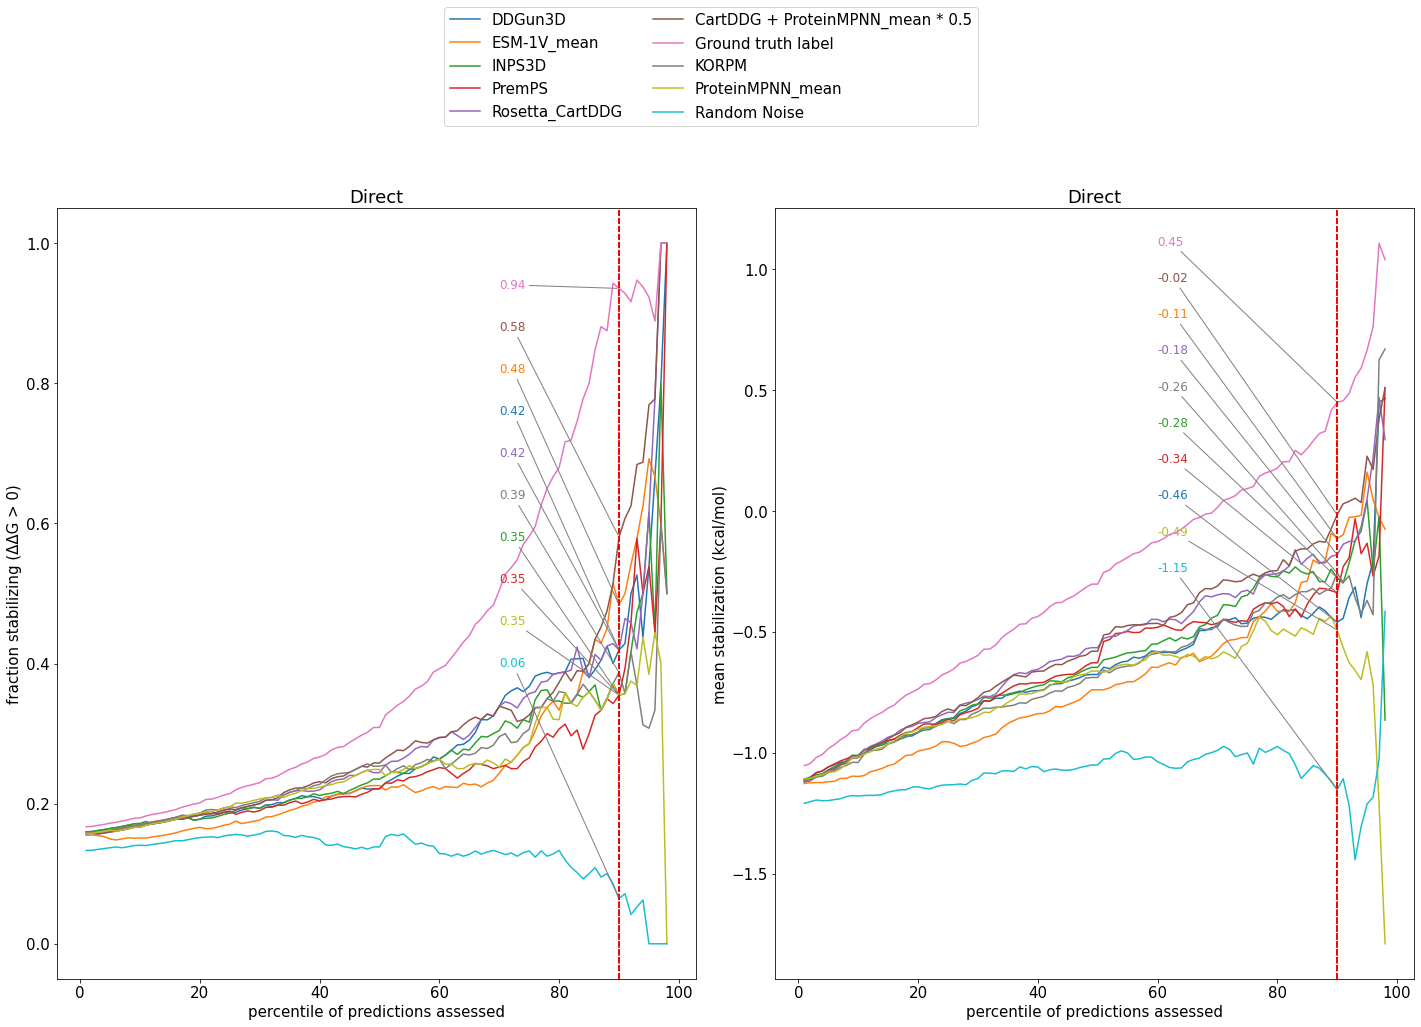

In [ ]:
analysis_utils.recovery_curves_2(dr, ['cartesian_ddg + mpnn_mean * 0.5', 'mpnn_mean', 'PremPS', 'cartesian_ddg', 'esm1v_mean', 'PremPS', 'korpm', 'DDGun3D', 'INPS3D', 'ddG', 'random'], percentile_labels=[90], directions=['dir'])

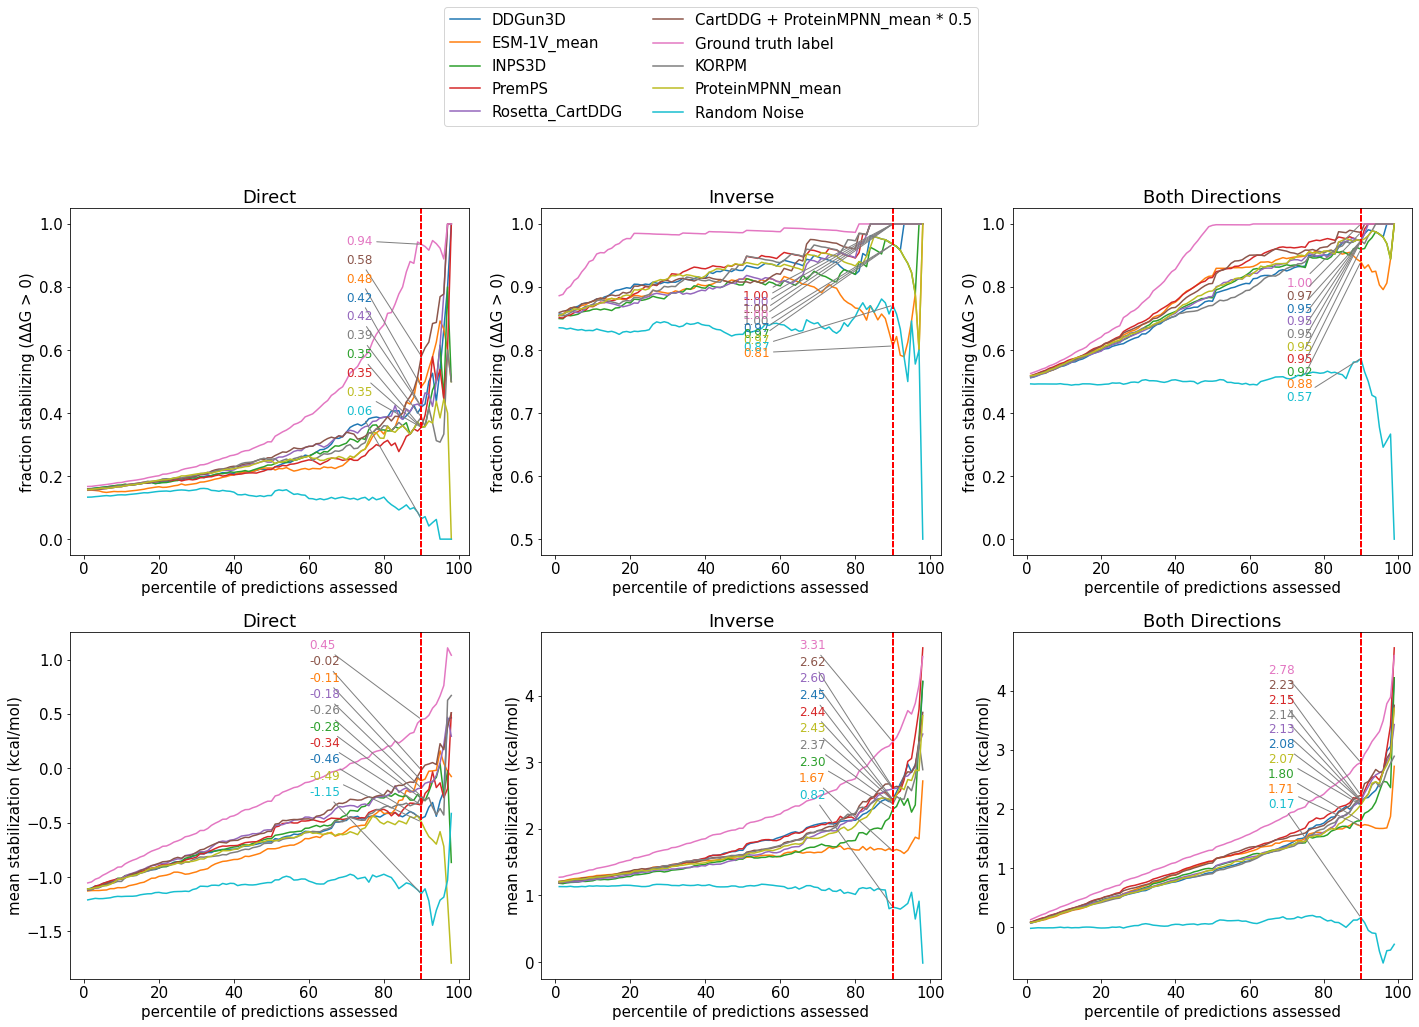

In [ ]:
analysis_utils.recovery_curves_2(dr, ['cartesian_ddg + mpnn_mean * 0.5', 'mpnn_mean', 'PremPS', 'cartesian_ddg', 'esm1v_mean', 'PremPS', 'korpm', 'DDGun3D', 'INPS3D', 'ddG', 'random'], directions=['dir', 'inv'], percentile_labels=[90])

In [ ]:
pd.concat([dr.xs('dir').sort_values('90%', ascending=False).head(10)[['90%', '90$', 'net_stabilization']], dr.xs('dir').sort_values('90$', ascending=False).head(10).tail(9)[['90%', '90$', 'net_stabilization']]])

90%       90$  \
model_type model                                                     
structural ddG                                  0.935484  0.450097   
           mif + ACDC-NN-Seq * 0.5              0.612903  0.031226   
           I-Mutant3.0 + mifst * 1              0.612903  0.000226   
           mif + DDGun3D * 1                    0.612903 -0.030710   
           esm1v_mean + mif * 1                 0.612903  0.064968   
           esm1v_median + mif * 1               0.612903  0.094000   
           mifst + DDGun3D * 1                  0.612903 -0.025161   
           mifst + DDGun3D * 0.5                0.612903 -0.072161   
           mifst + SAAFEC-Seq * 1               0.612903  0.000226   
           mif + esm1v_median * 1               0.612903  0.094000   
           esmif_monomer + ACDC-NN-Seq * 0.5    0.580645  0.101323   
           mif + esm1v_median * 1               0.612903  0.094000   
           esm1v_median + mif * 1               0.612903  0.094000   
           korpm + msa_transformer_mean * 0.5   0.516129  0.088032   
           esmif_monomer + esm1v_median * 0.2   0.516129  0.083903   
           esmif_multimer + esm1v_median * 0.2  0.516129  0.080677   
           esmif_multimer + esm1v_mean * 0.2    0.516129  0.080677   
           esmif_monomer + esm1v_mean * 0.2     0.516129  0.080032   
           esmif_monomer + ACDC-NN * 0.5        0.516129  0.070032   

                                                net_stabilization  
model_type model                                                   
structural ddG                                             36.998  
           mif + ACDC-NN-Seq * 0.5                          2.560  
           I-Mutant3.0 + mifst * 1                          5.428  
           mif + DDGun3D * 1                                6.652  
           esm1v_mean + mif * 1                             8.598  
           esm1v_median + mif * 1                           6.618  
           mifst + DDGun3D * 1                              6.607  
           mifst + DDGun3D * 0.5                            6.606  
           mifst + SAAFEC-Seq * 1                           5.428  
           mif + esm1v_median * 1                           6.618  
           esmif_monomer + ACDC-NN-Seq * 0.5                0.783  
           mif + esm1v_median * 1                           6.618  
           esm1v_median + mif * 1                           6.618  
           korpm + msa_transformer_mean * 0.5              13.278  
           esmif_monomer + esm1v_median * 0.2               3.125  
           esmif_multimer + esm1v_median * 0.2              2.916  
           esmif_multimer + esm1v_mean * 0.2                2.216  
           esmif_monomer + esm1v_mean * 0.2                 1.266  
           esmif_monomer + ACDC-NN * 0.5                   -2.630